In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

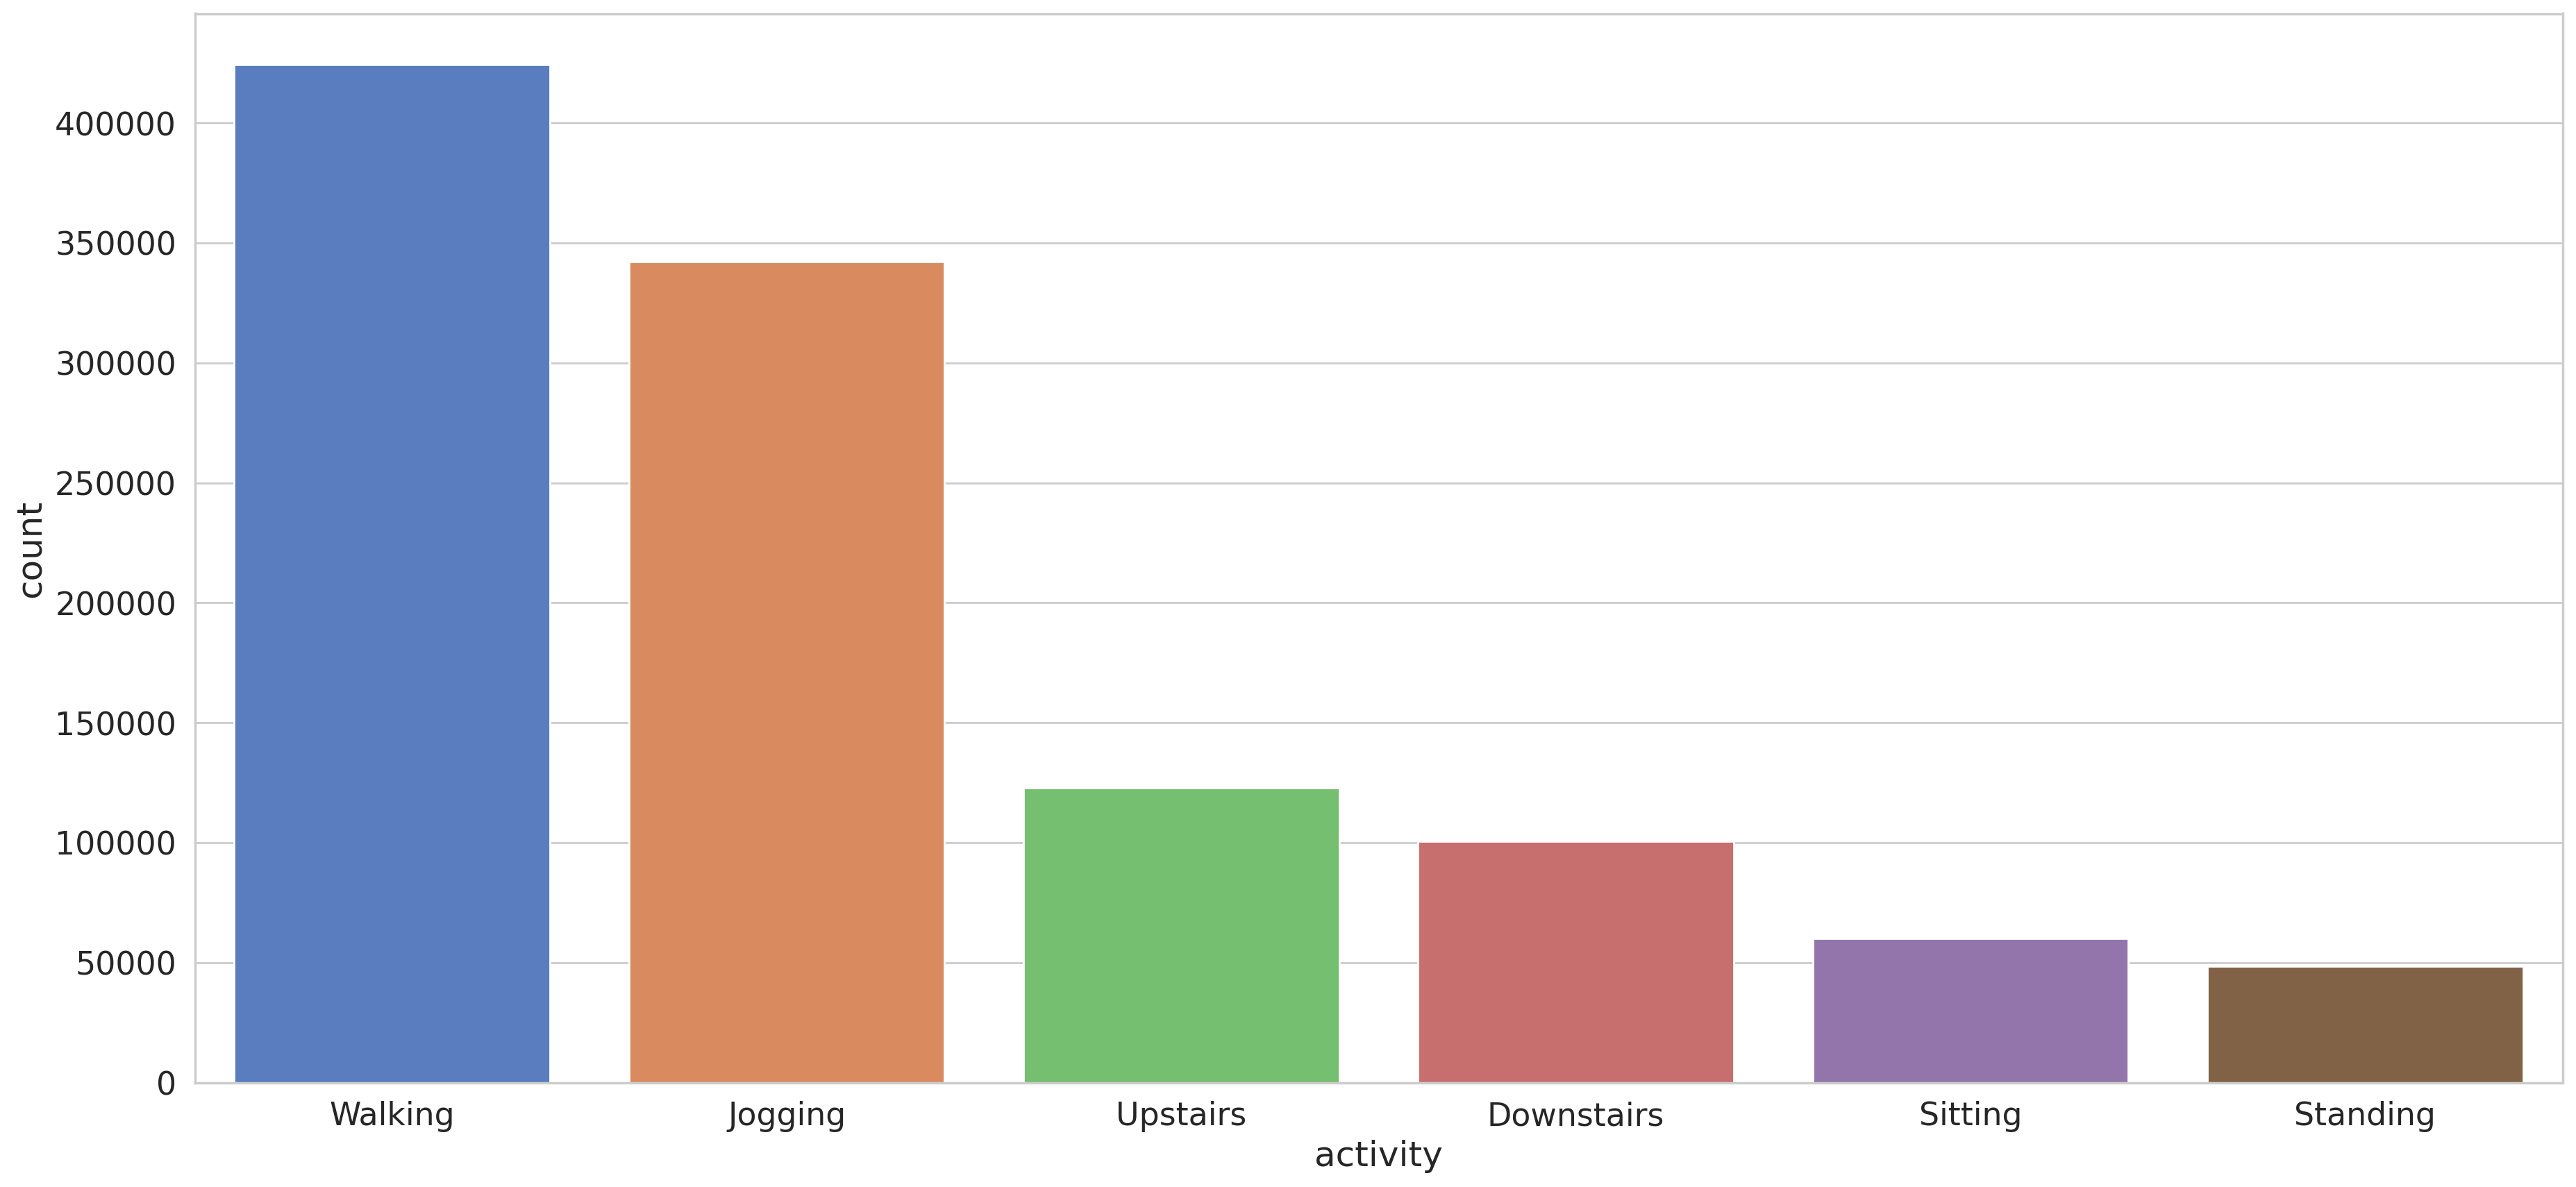

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

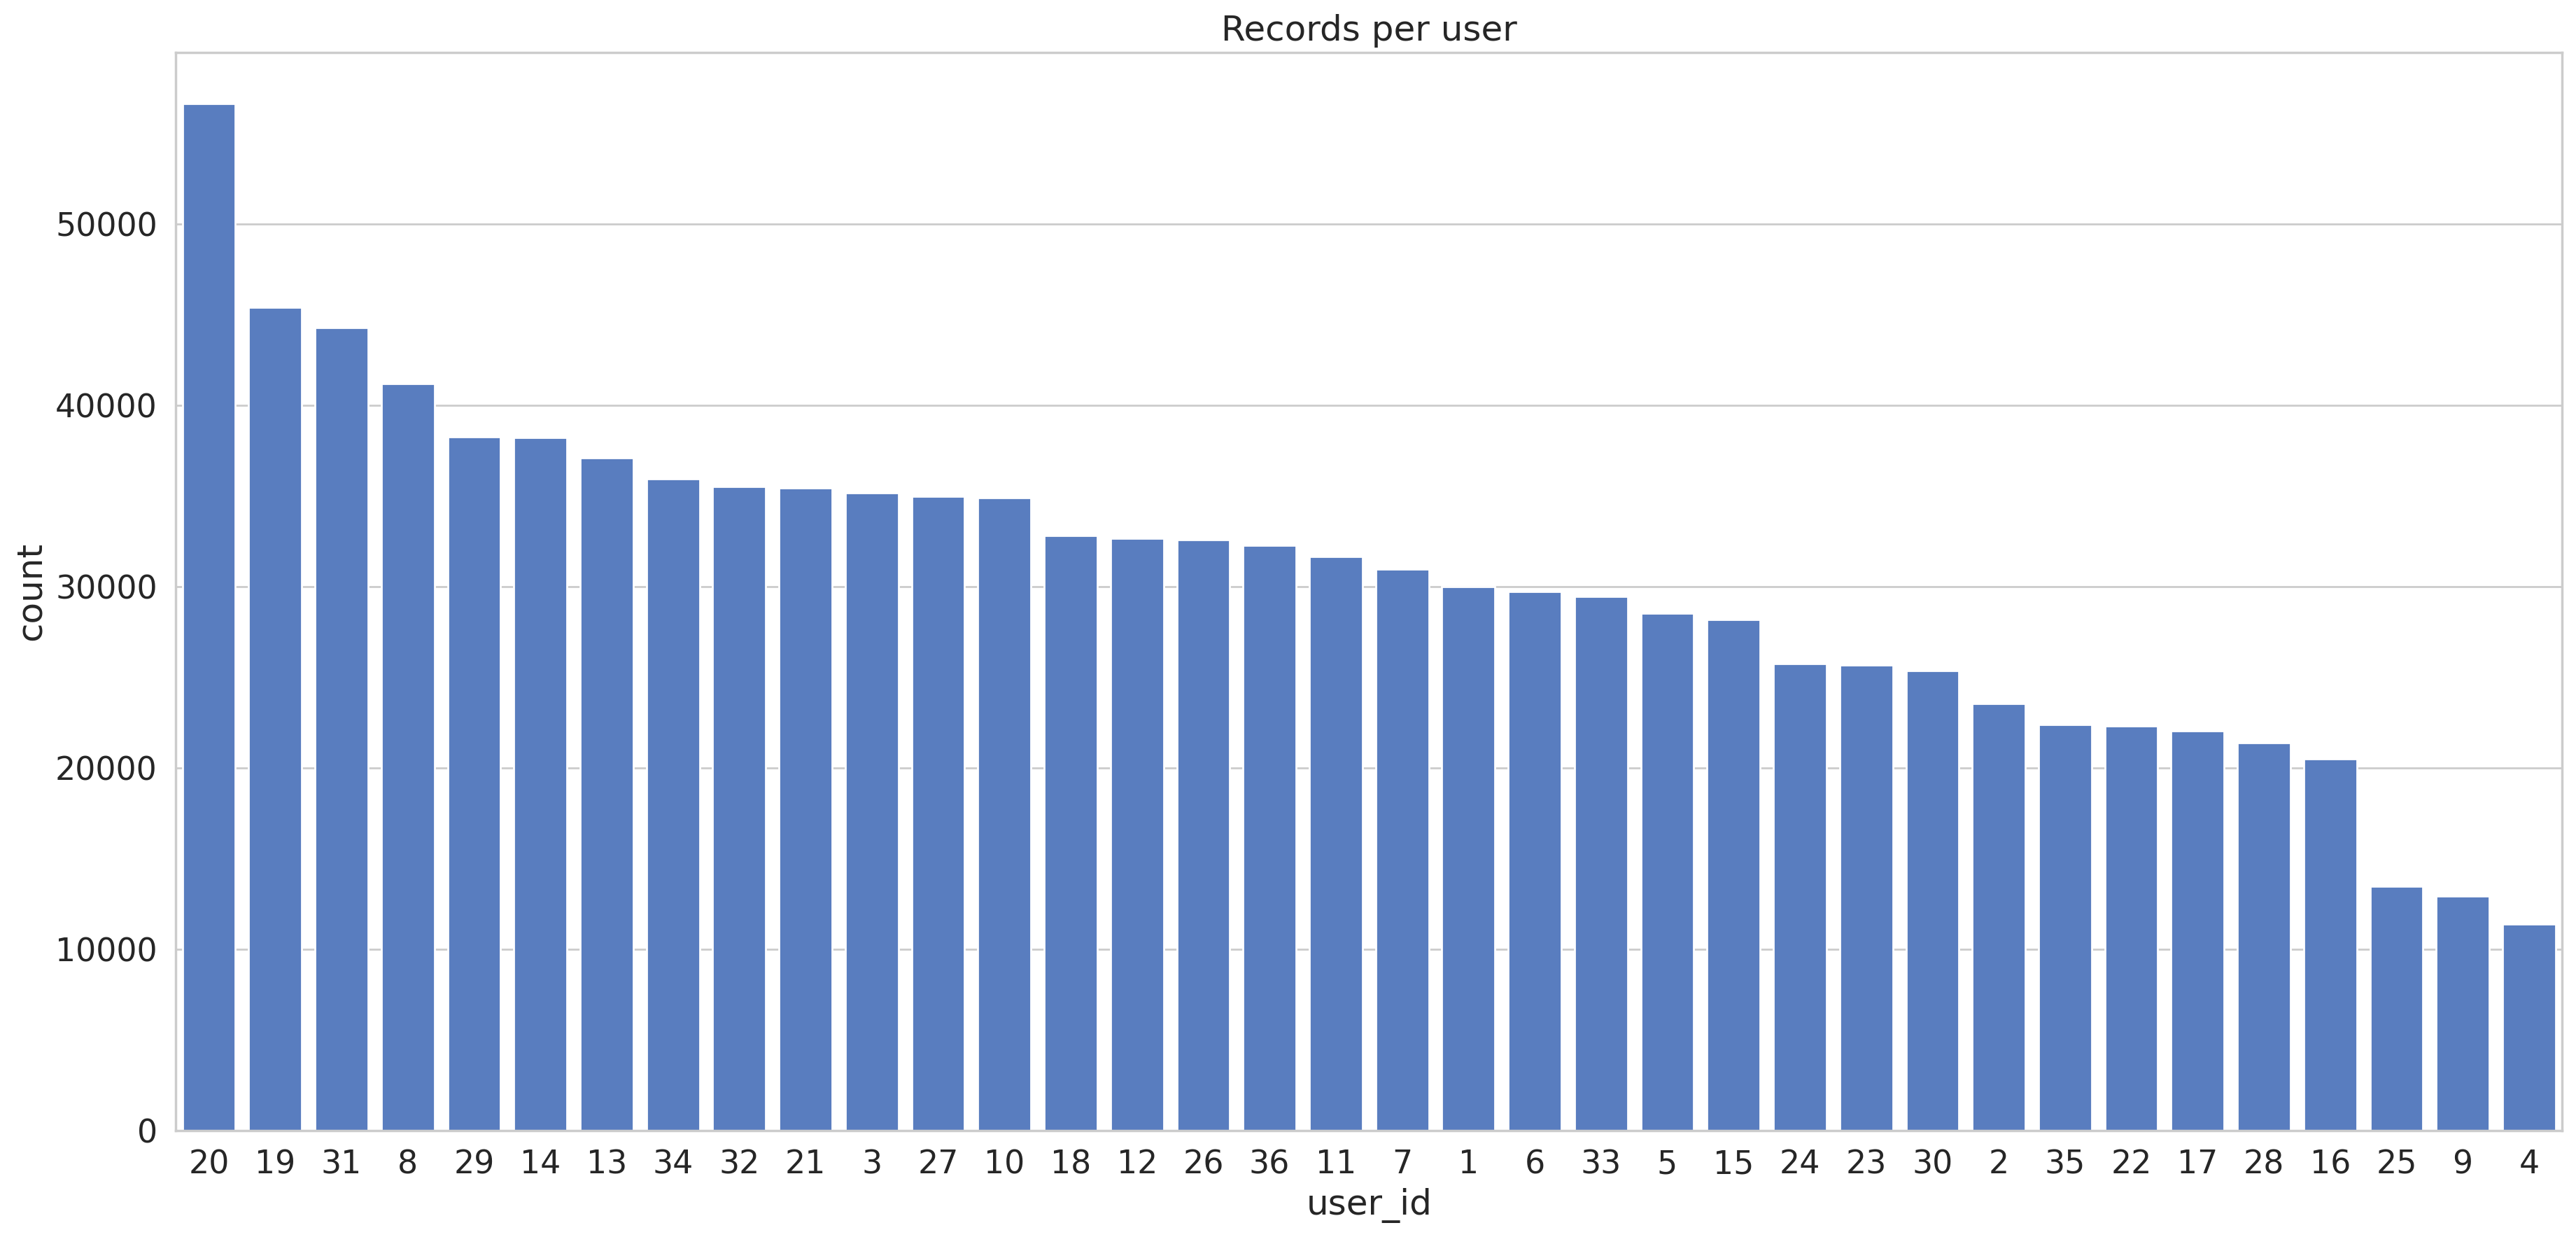

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


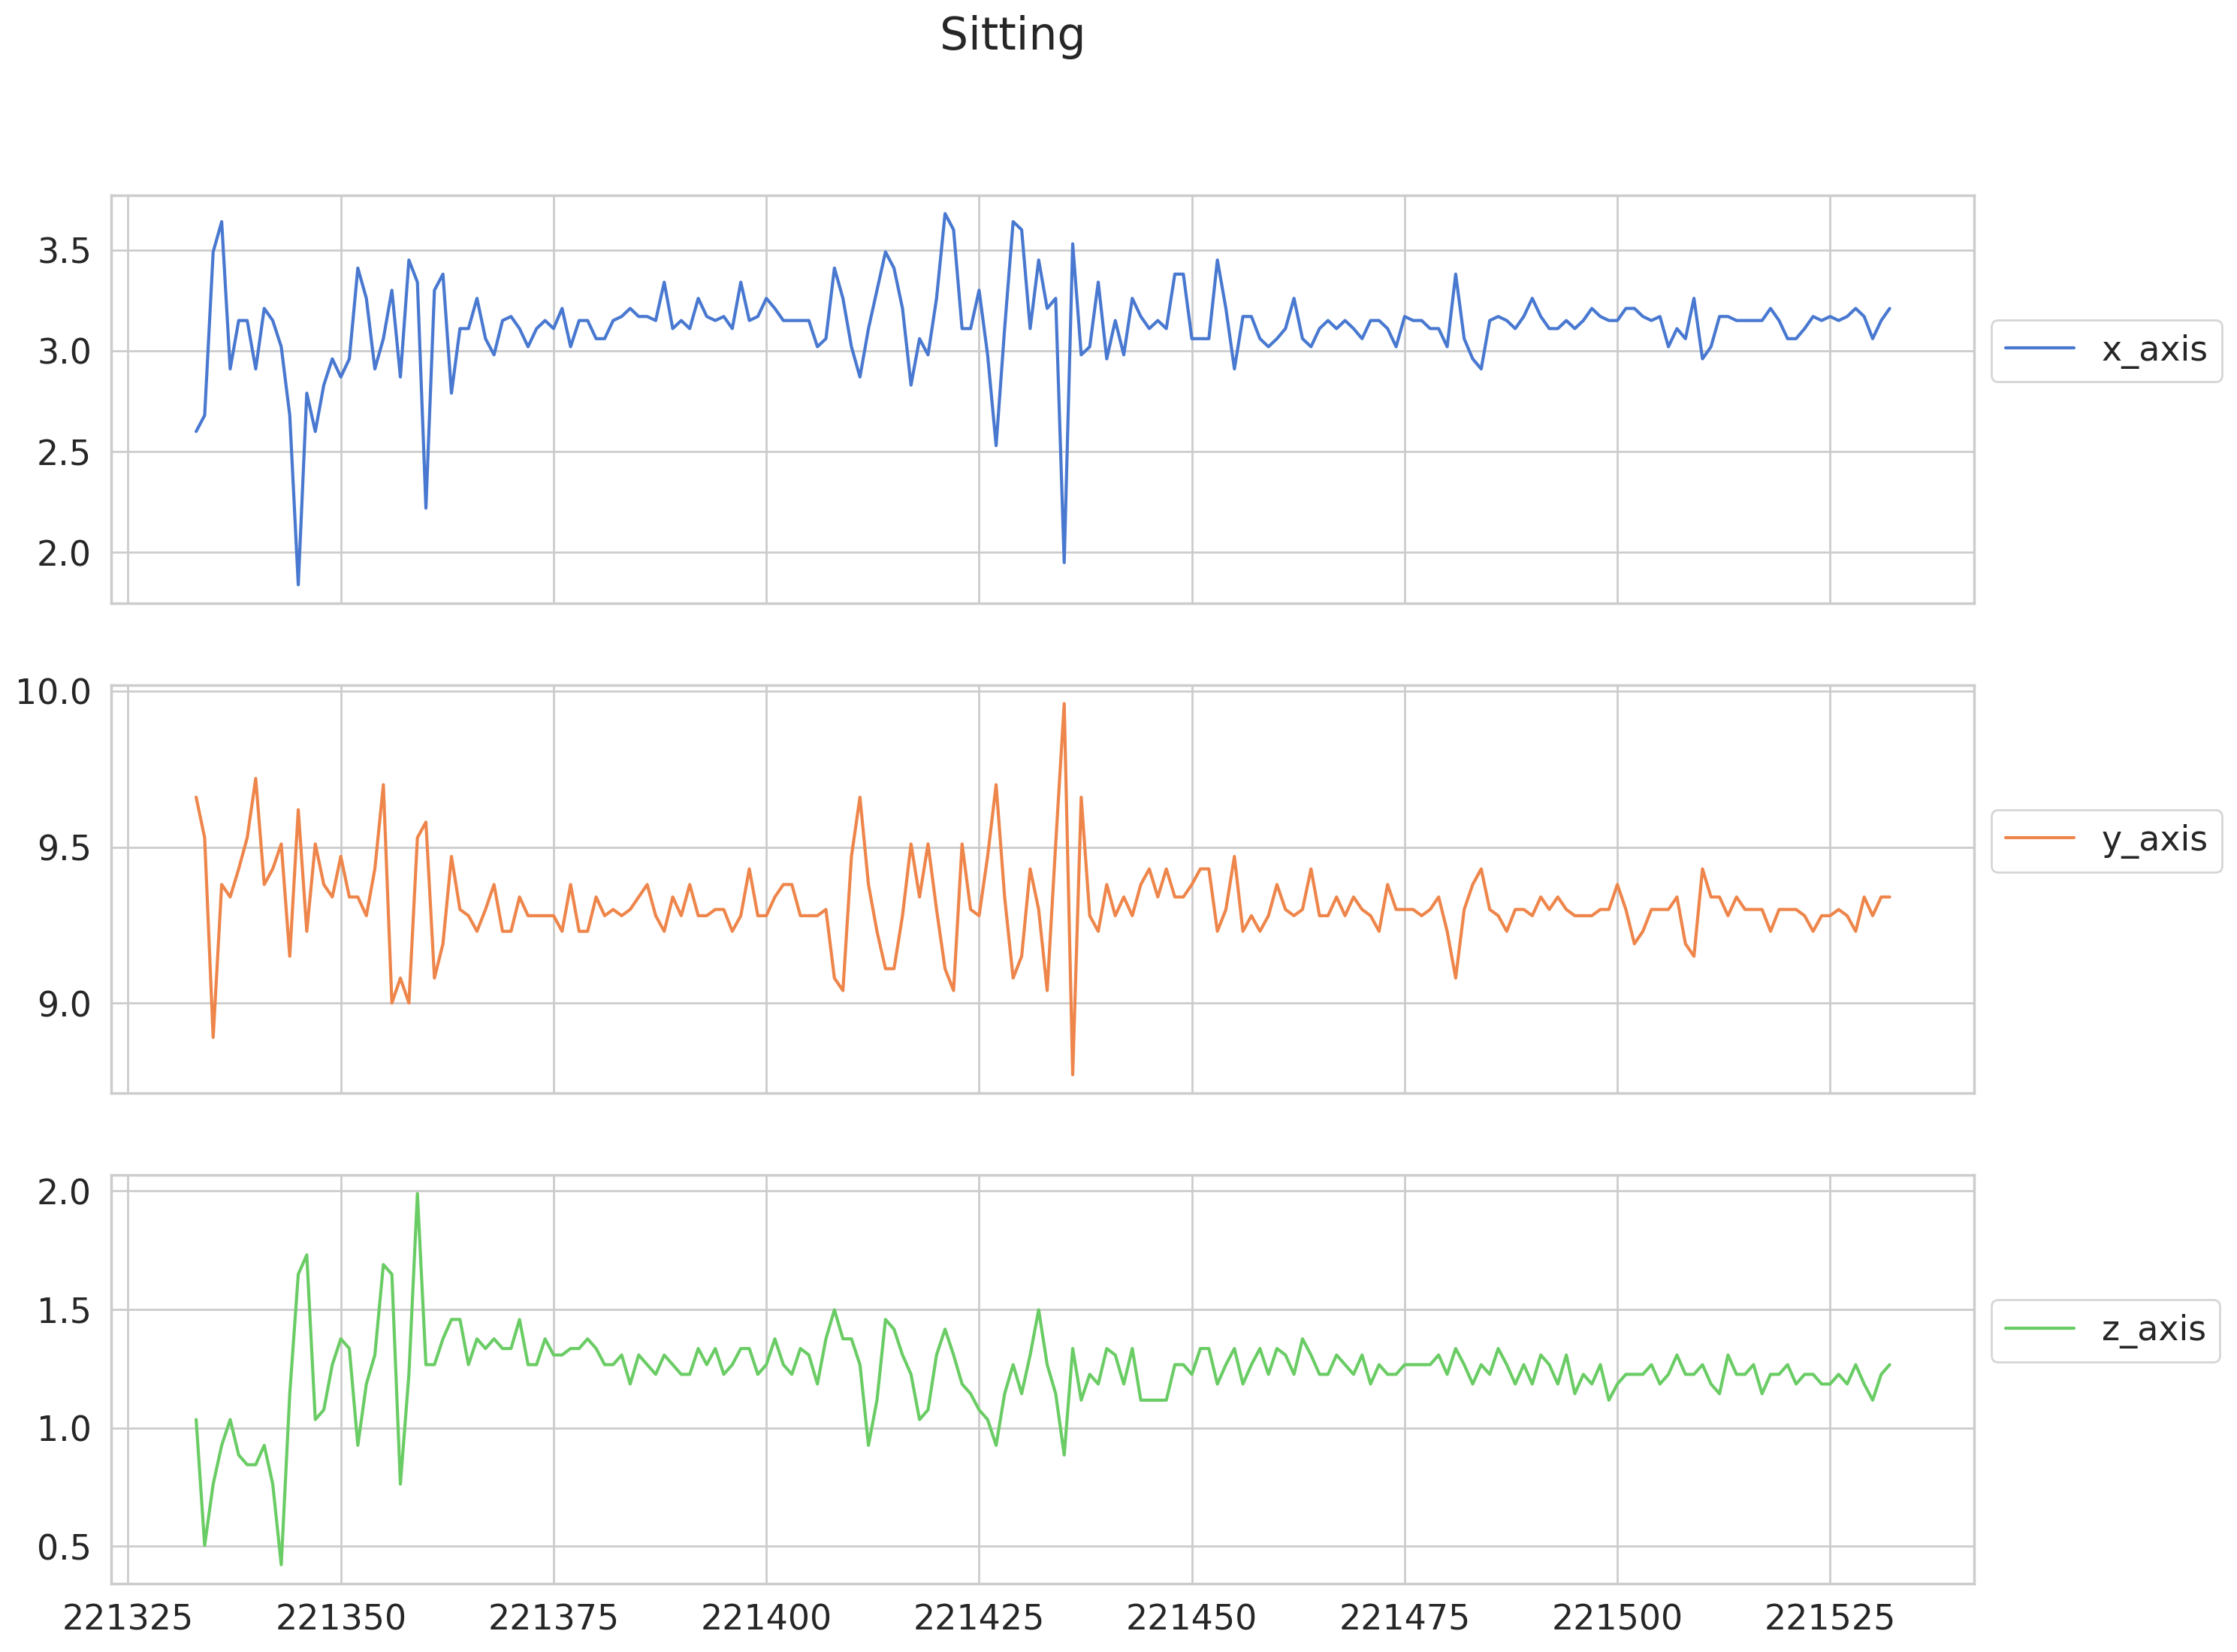

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)


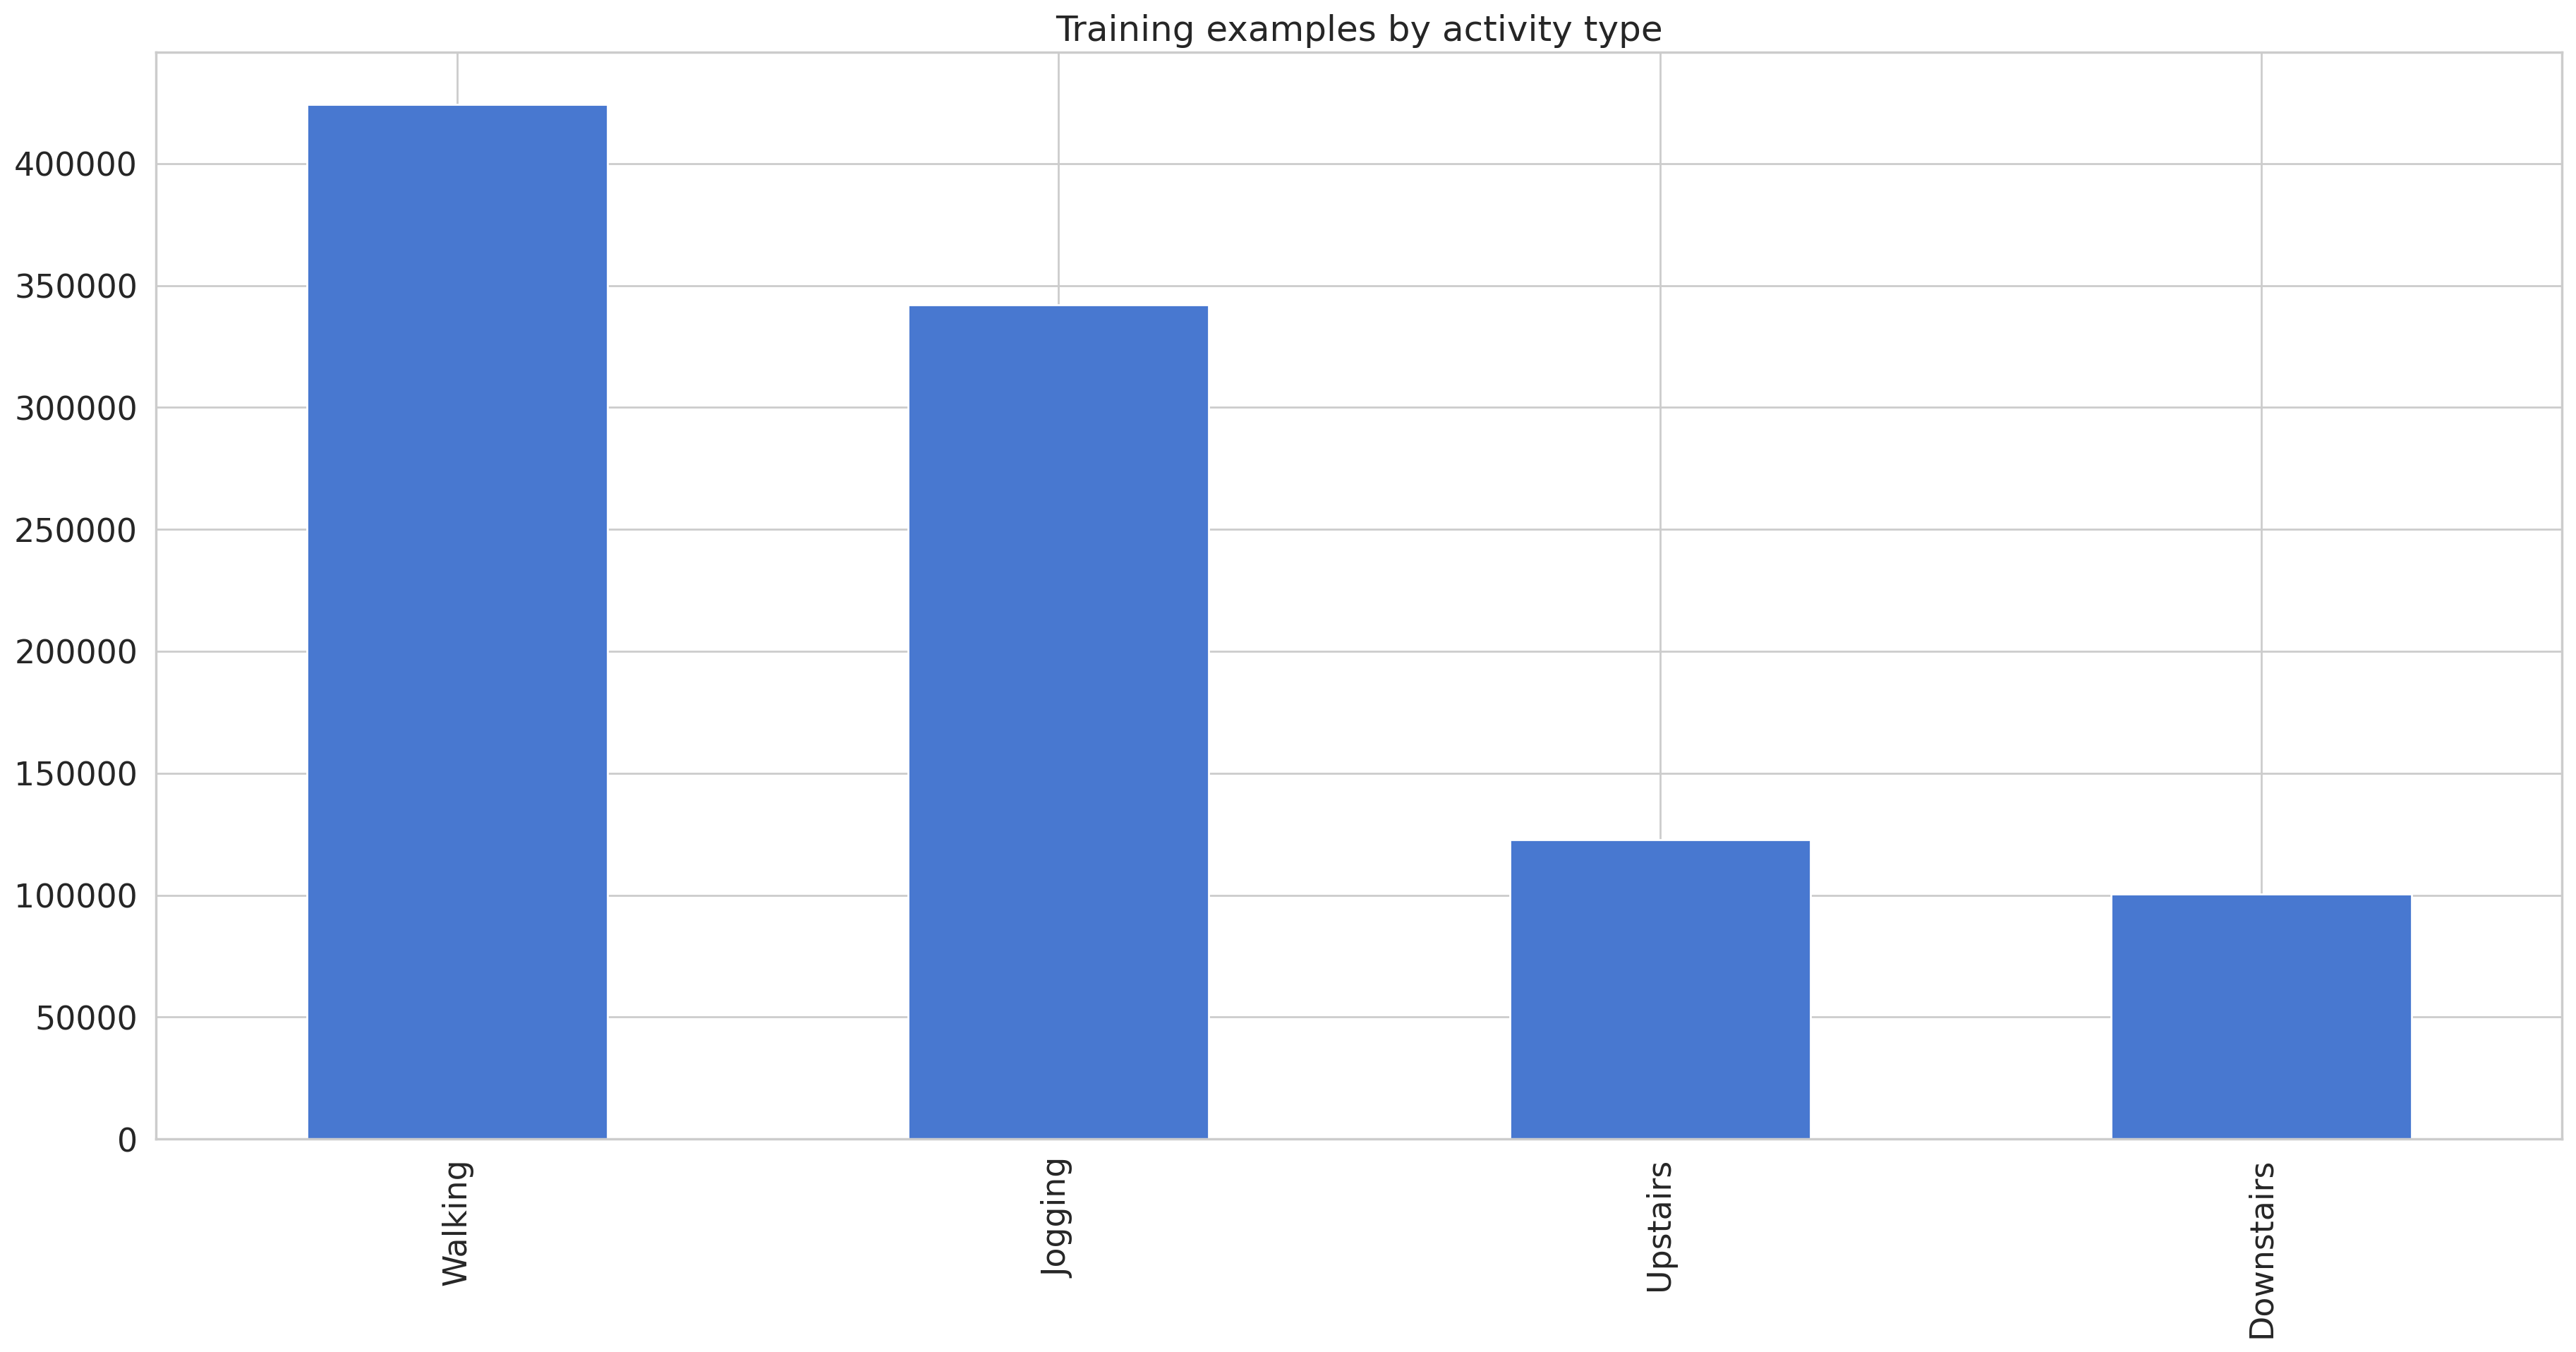

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.139064,0.528798,0.162904,1
1,33,Jogging,49106062271000,0.627996,0.365980,0.257510,1
2,33,Jogging,49106112167000,0.613350,0.322145,0.039629,1
3,33,Jogging,49106222305000,-0.128080,1.197291,0.693271,1
4,33,Jogging,49106332290000,-0.204969,0.463045,1.573395,1
...,...,...,...,...,...,...,...
1093534,19,Downstairs,131357151521000,-0.602151,-0.017241,0.635659,3
1093535,19,Downstairs,131357191438000,-0.987903,0.155172,0.248370,3
1093536,19,Downstairs,131357231630000,-1.235215,0.718391,0.119975,3
1093537,19,Downstairs,131357271516000,-1.065860,0.026437,-0.524103,3


In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63348, 50, 3) (63348, 1)
(19797, 50, 3) (19797, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(63348, 50, 3) (63348, 4) (19797, 50, 3) (19797, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 4)

# GRU1


In [15]:
# Sequential model type
model = Sequential()
model.add(Bidirectional(GRU(units=128, input_shape = (n_timesteps,n_features))))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [16]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
62/62 [==============================] - 93s 1s/step - loss: 0.9740 - accuracy: 0.6367 - val_loss: 0.6578 - val_accuracy: 0.7609
Epoch 2/10
62/62 [==============================] - 87s 1s/step - loss: 0.5713 - accuracy: 0.7881 - val_loss: 0.4930 - val_accuracy: 0.8094
Epoch 3/10
62/62 [==============================] - 92s 1s/step - loss: 0.4737 - accuracy: 0.8183 - val_loss: 0.4378 - val_accuracy: 0.8325
Epoch 4/10
62/62 [==============================] - 88s 1s/step - loss: 0.4241 - accuracy: 0.8371 - val_loss: 0.3912 - val_accuracy: 0.8469
Epoch 5/10
62/62 [==============================] - 86s 1s/step - loss: 0.3782 - accuracy: 0.8548 - val_loss: 0.3582 - val_accuracy: 0.8645
Epoch 6/10
62/62 [==============================] - 84s 1s/step - loss: 0.3302 - accuracy: 0.8734 - val_loss: 0.3026 - val_accuracy: 0.8827
Epoch 7/10
62/62 [==============================] - 87s 1s/step - loss: 0.2791 - accuracy: 0.8952 - val_loss: 0.2511 - val_accuracy: 0.9065
Epoch 8/10
62/62 [==

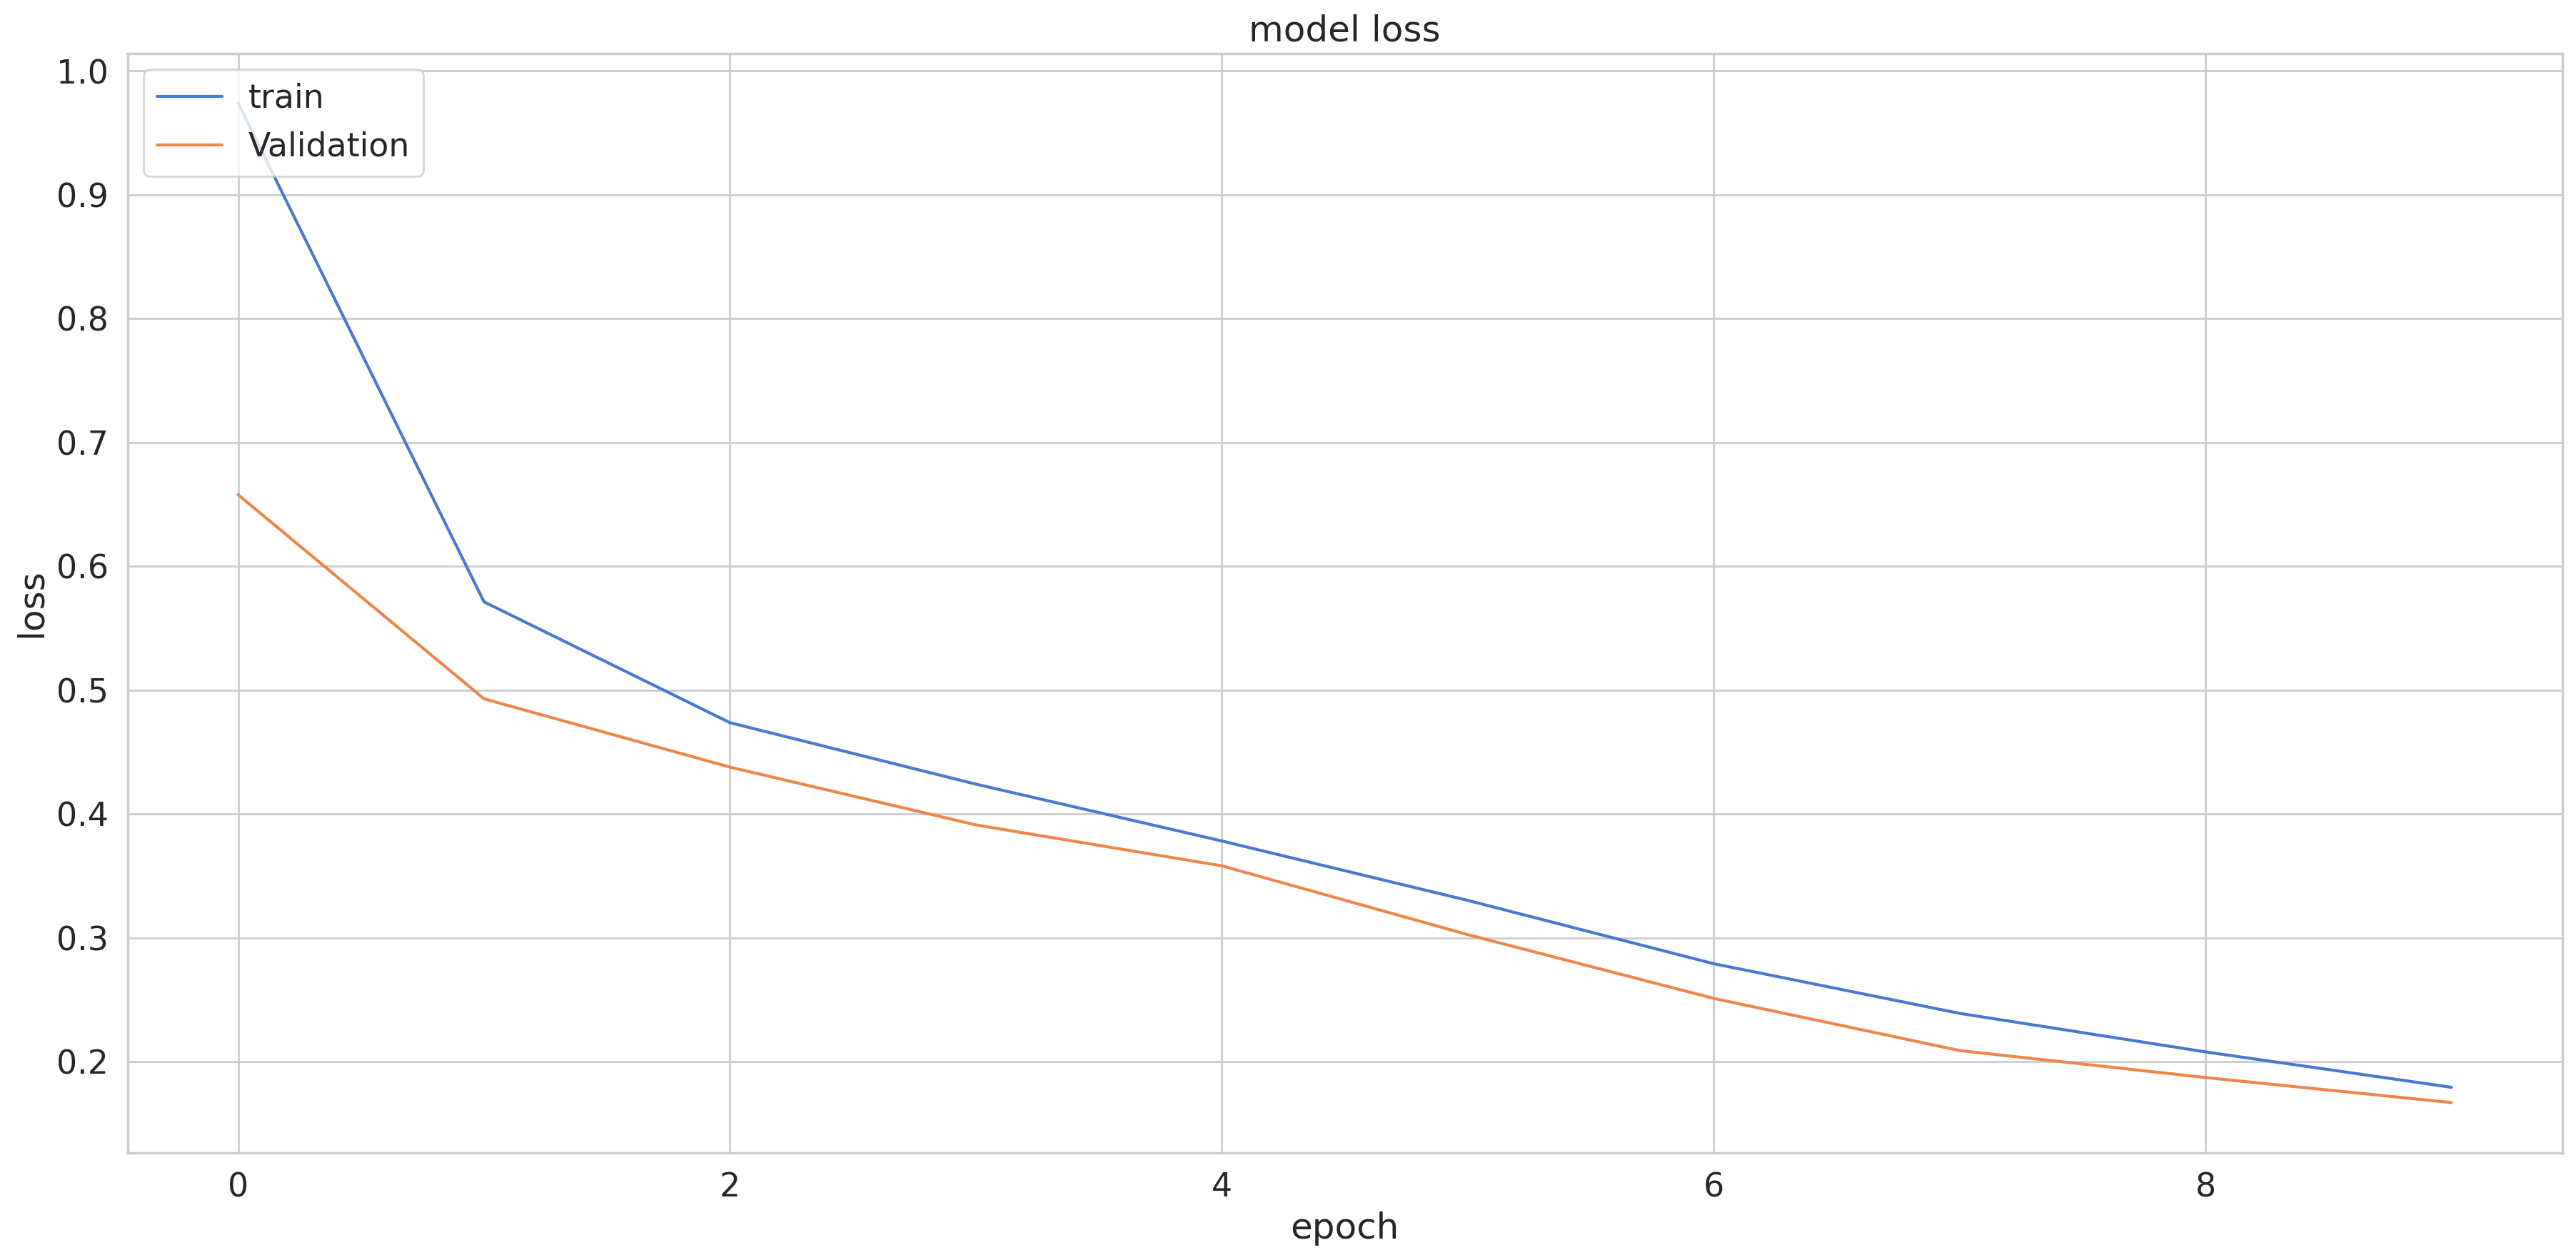

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

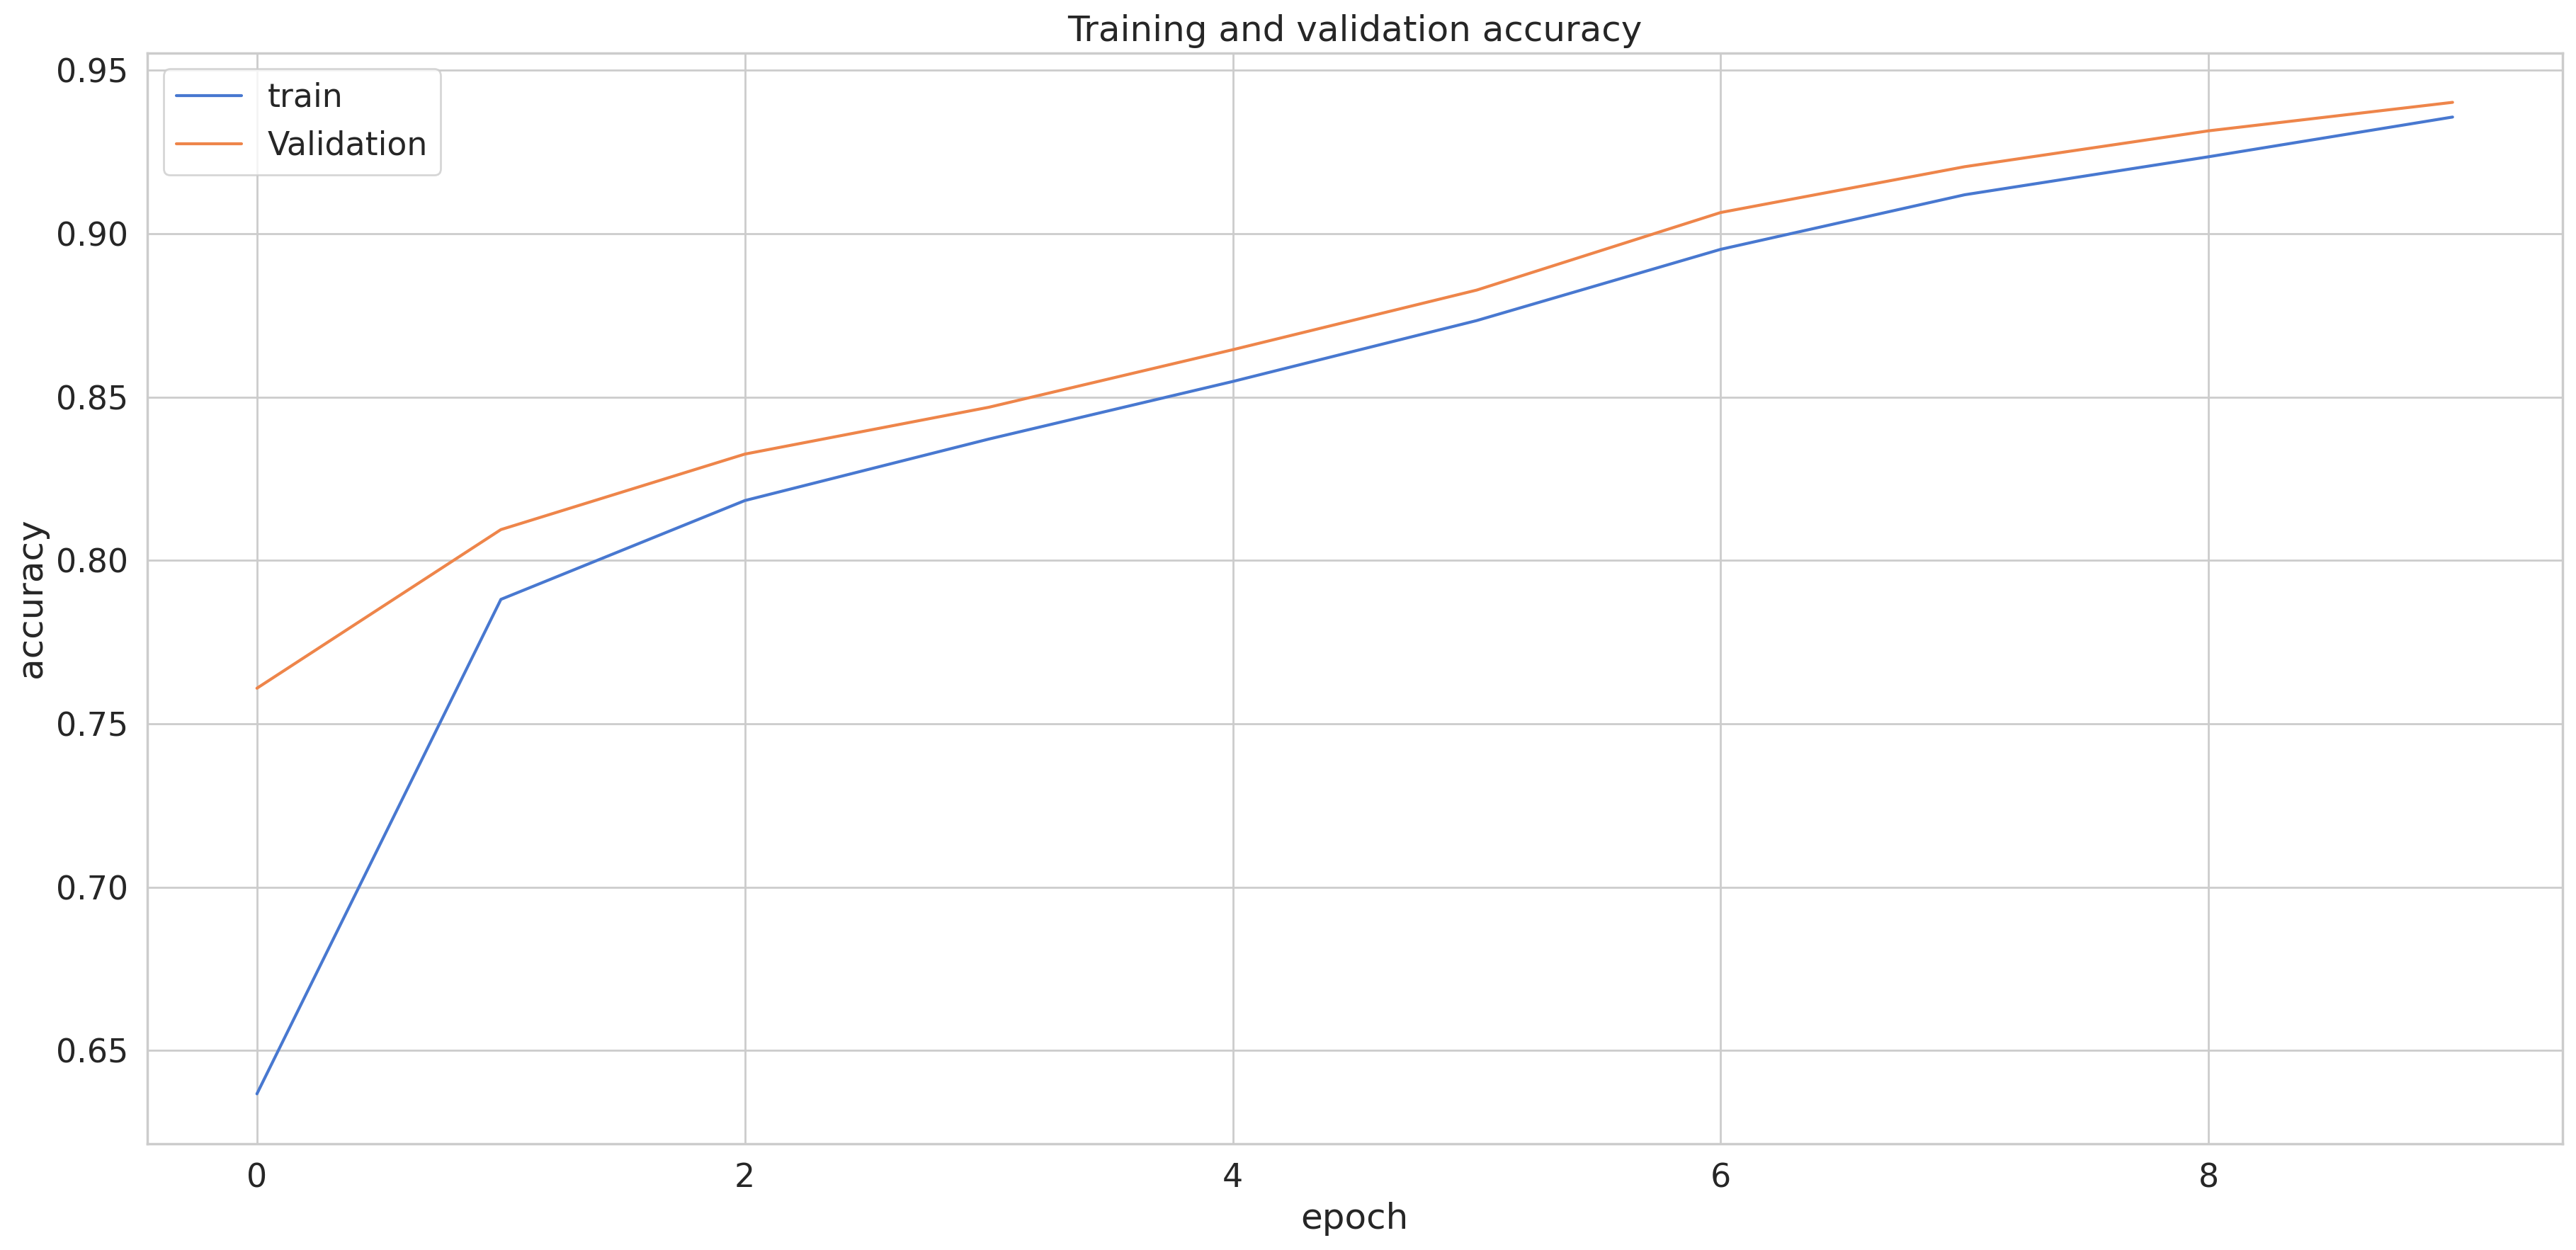

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 14s 20ms/step
f1_score =  0.9370575426017858
0.9384755265949386
              precision    recall  f1-score   support

           0       0.97      0.99      0.97      8490
           1       0.98      0.98      0.98      6843
           2       0.79      0.87      0.83      2459
           3       0.86      0.67      0.76      2005

    accuracy                           0.94     19797
   macro avg       0.90      0.88      0.89     19797
weighted avg       0.94      0.94      0.94     19797



<Axes: >

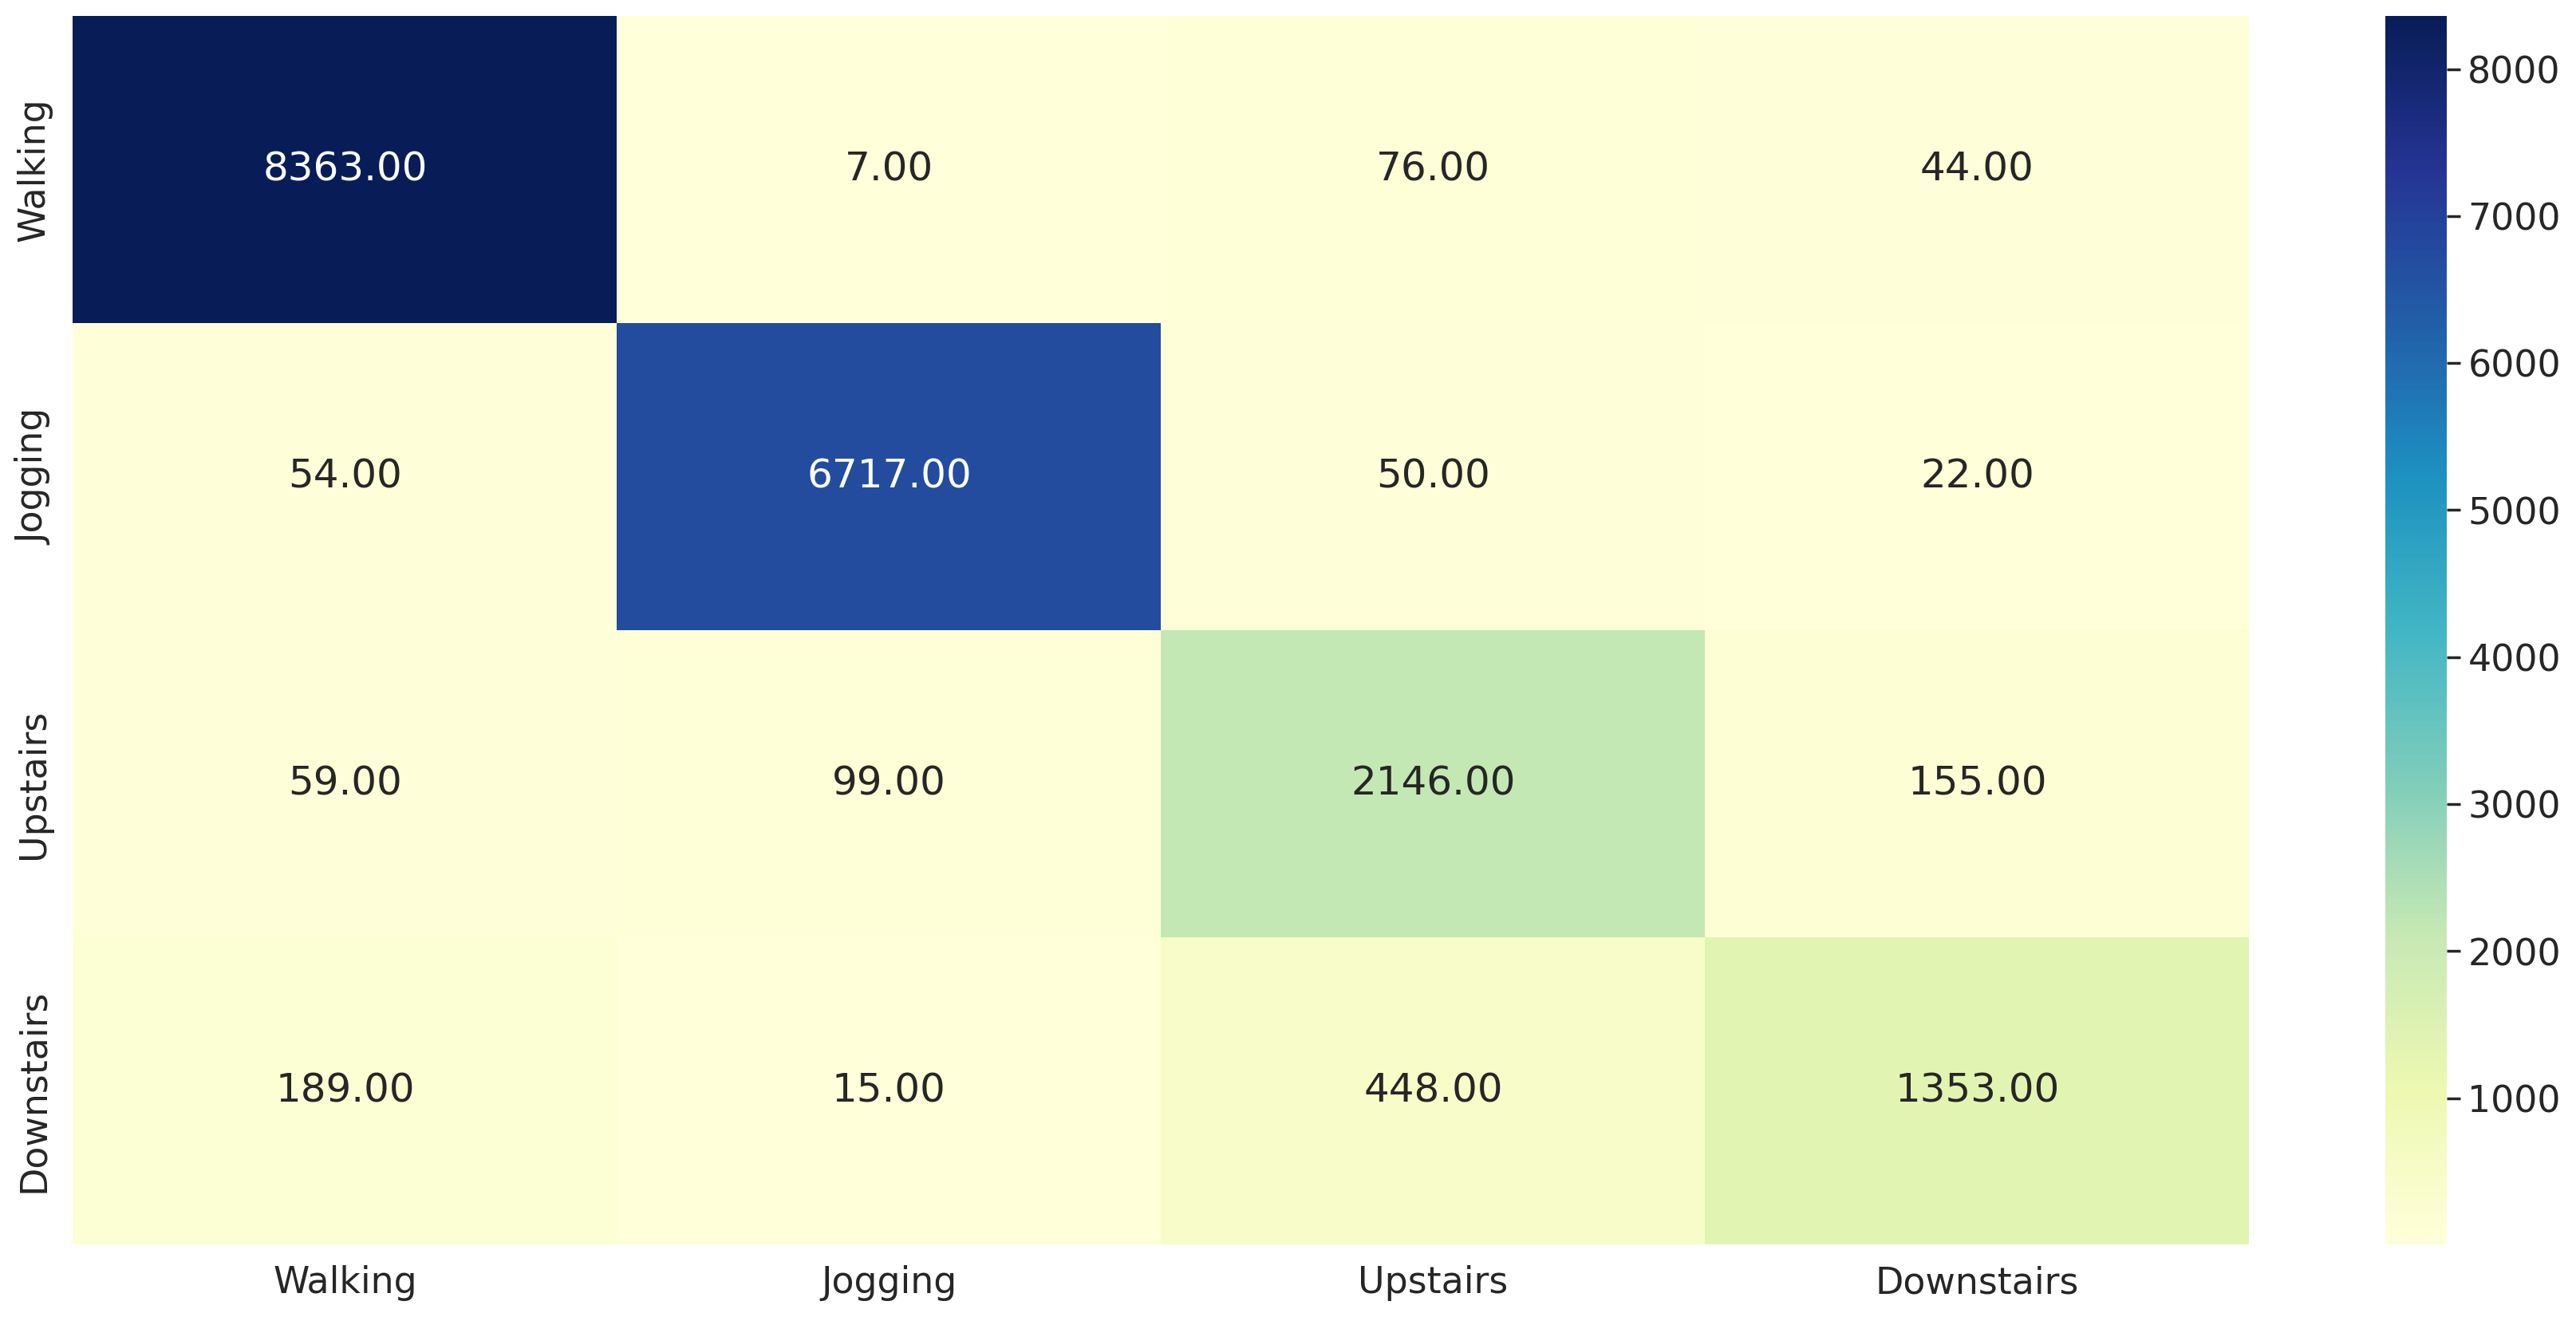

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU2

In [20]:
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 379s 744ms/step - loss: 0.5091 - accuracy: 0.8104 - val_loss: 0.2439 - val_accuracy: 0.9112
Epoch 2/10
495/495 [==============================] - 354s 714ms/step - loss: 0.1751 - accuracy: 0.9400 - val_loss: 0.1367 - val_accuracy: 0.9536
Epoch 3/10
495/495 [==============================] - 378s 764ms/step - loss: 0.1071 - accuracy: 0.9652 - val_loss: 0.1038 - val_accuracy: 0.9663
Epoch 4/10
495/495 [==============================] - 342s 691ms/step - loss: 0.0793 - accuracy: 0.9743 - val_loss: 0.0600 - val_accuracy: 0.9809
Epoch 5/10
495/495 [==============================] - 349s 706ms/step - loss: 0.0602 - accuracy: 0.9804 - val_loss: 0.0548 - val_accuracy: 0.9831
Epoch 6/10
495/495 [==============================] - 349s 706ms/step - loss: 0.0486 - accuracy: 0.9842 - val_loss: 0.0560 - val_accuracy: 0.9828
Epoch 7/10
495/495 [==============================] - 337s 681ms/step - loss: 0.0446 - accuracy: 0.9855 - val_loss: 0.0452 -

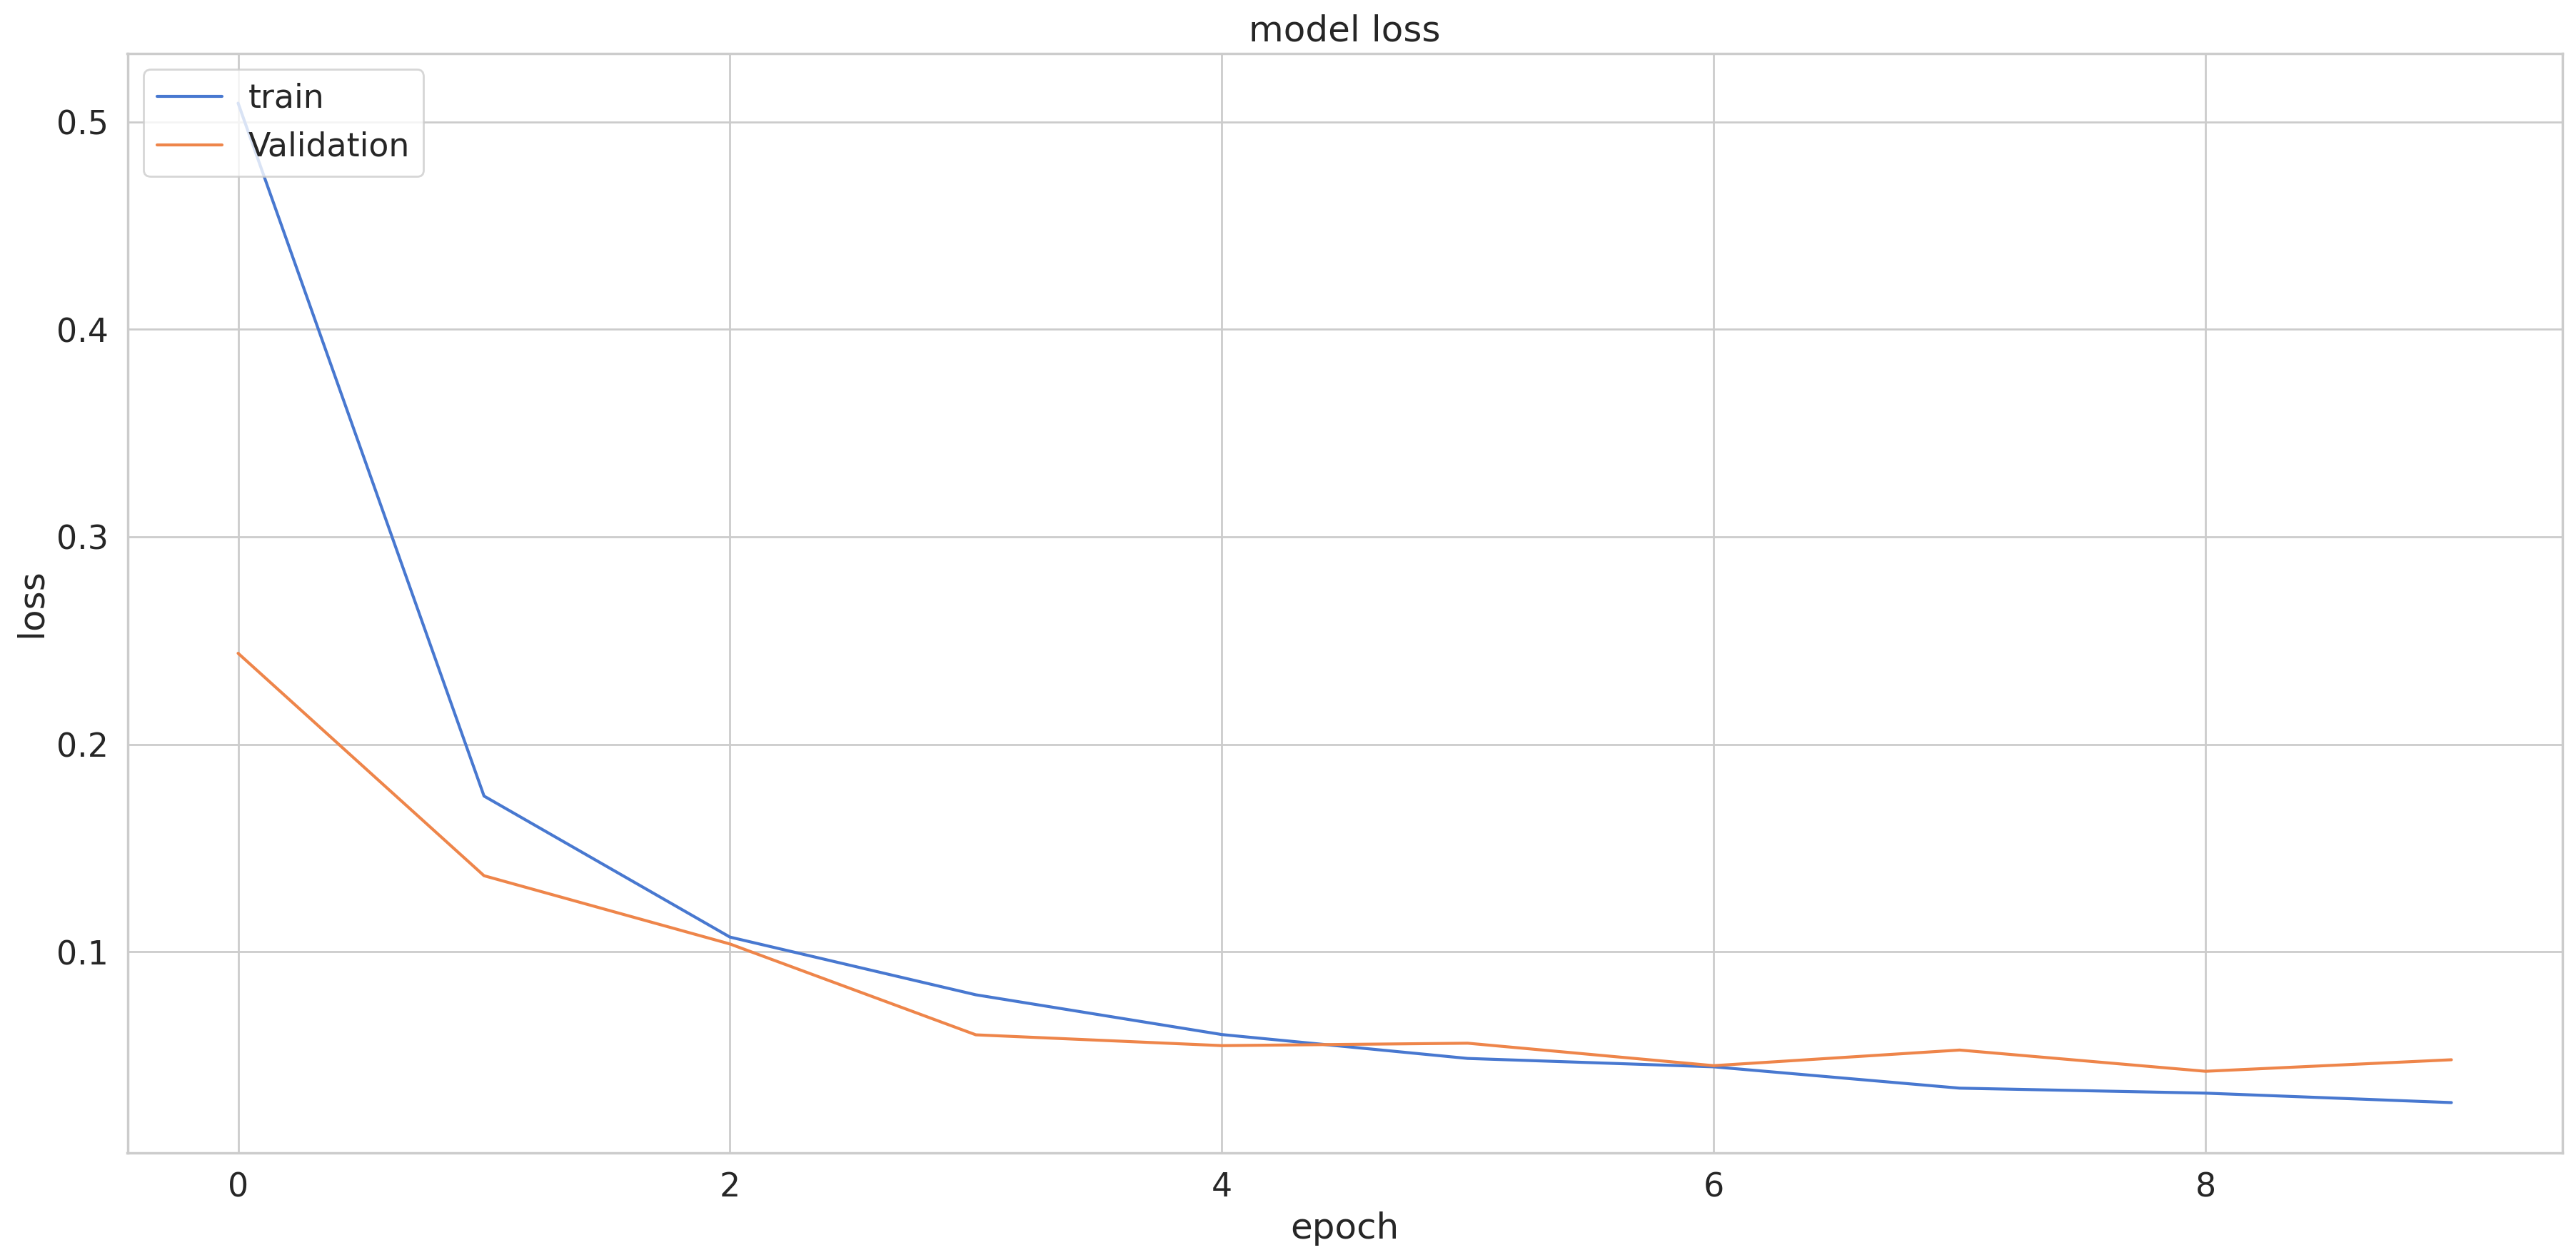

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

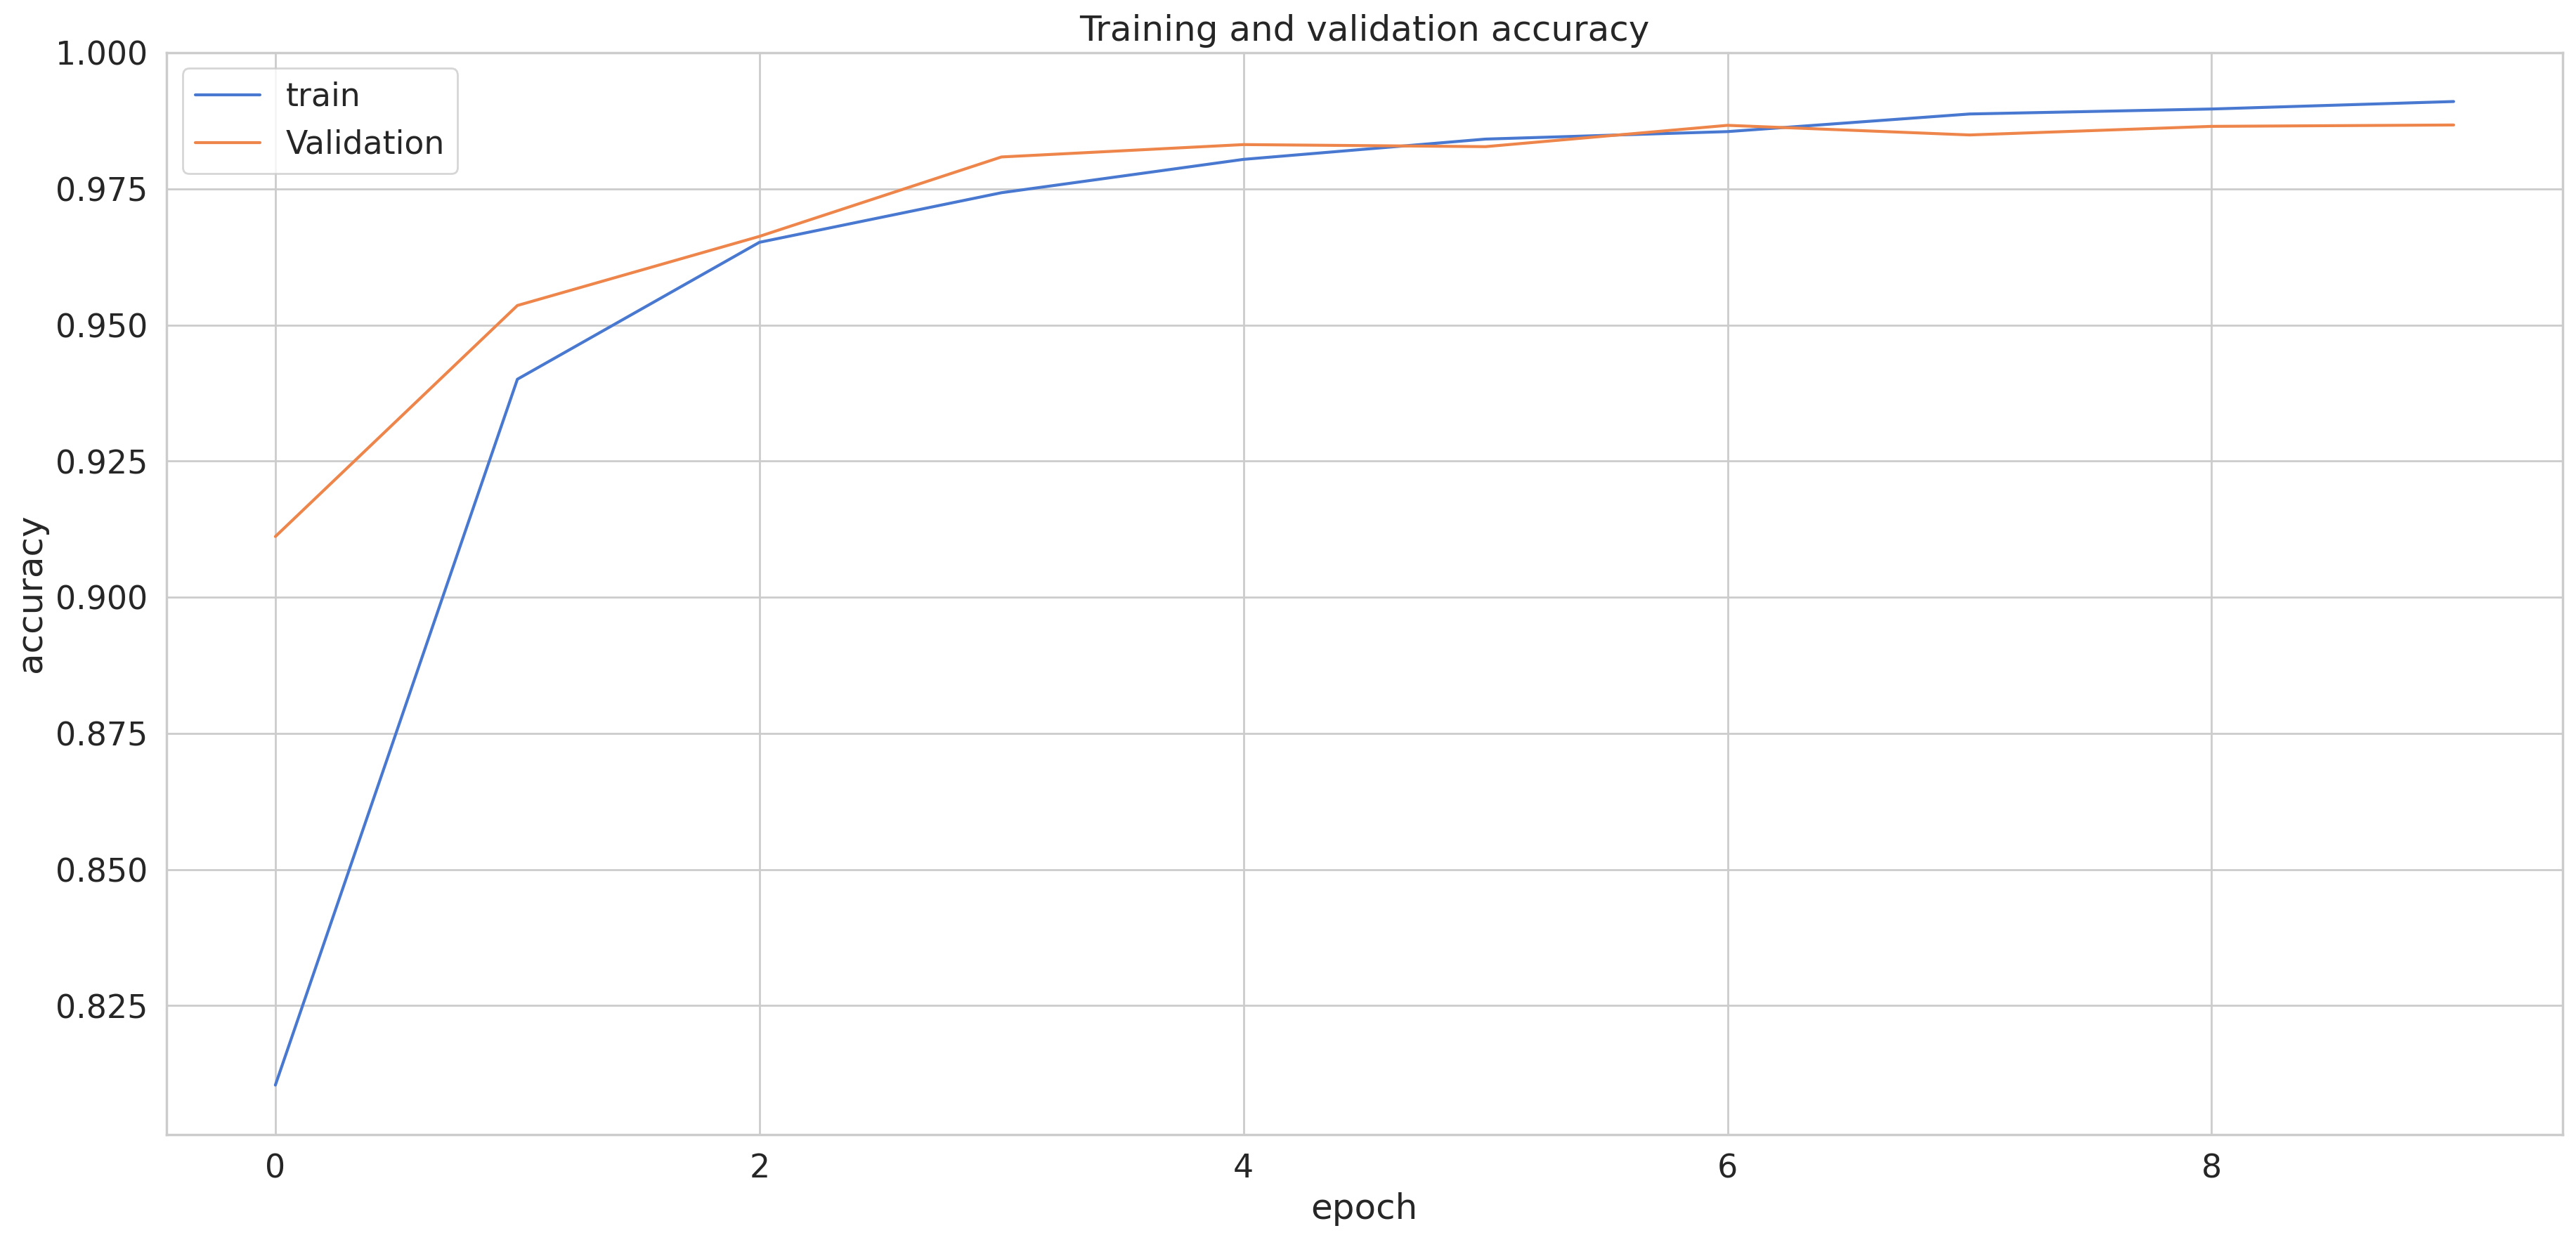

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 49s 77ms/step
f1_score =  0.9866257233814029
0.9865636207506188
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.96      0.97      0.96      2459
           3       0.95      0.97      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.97      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

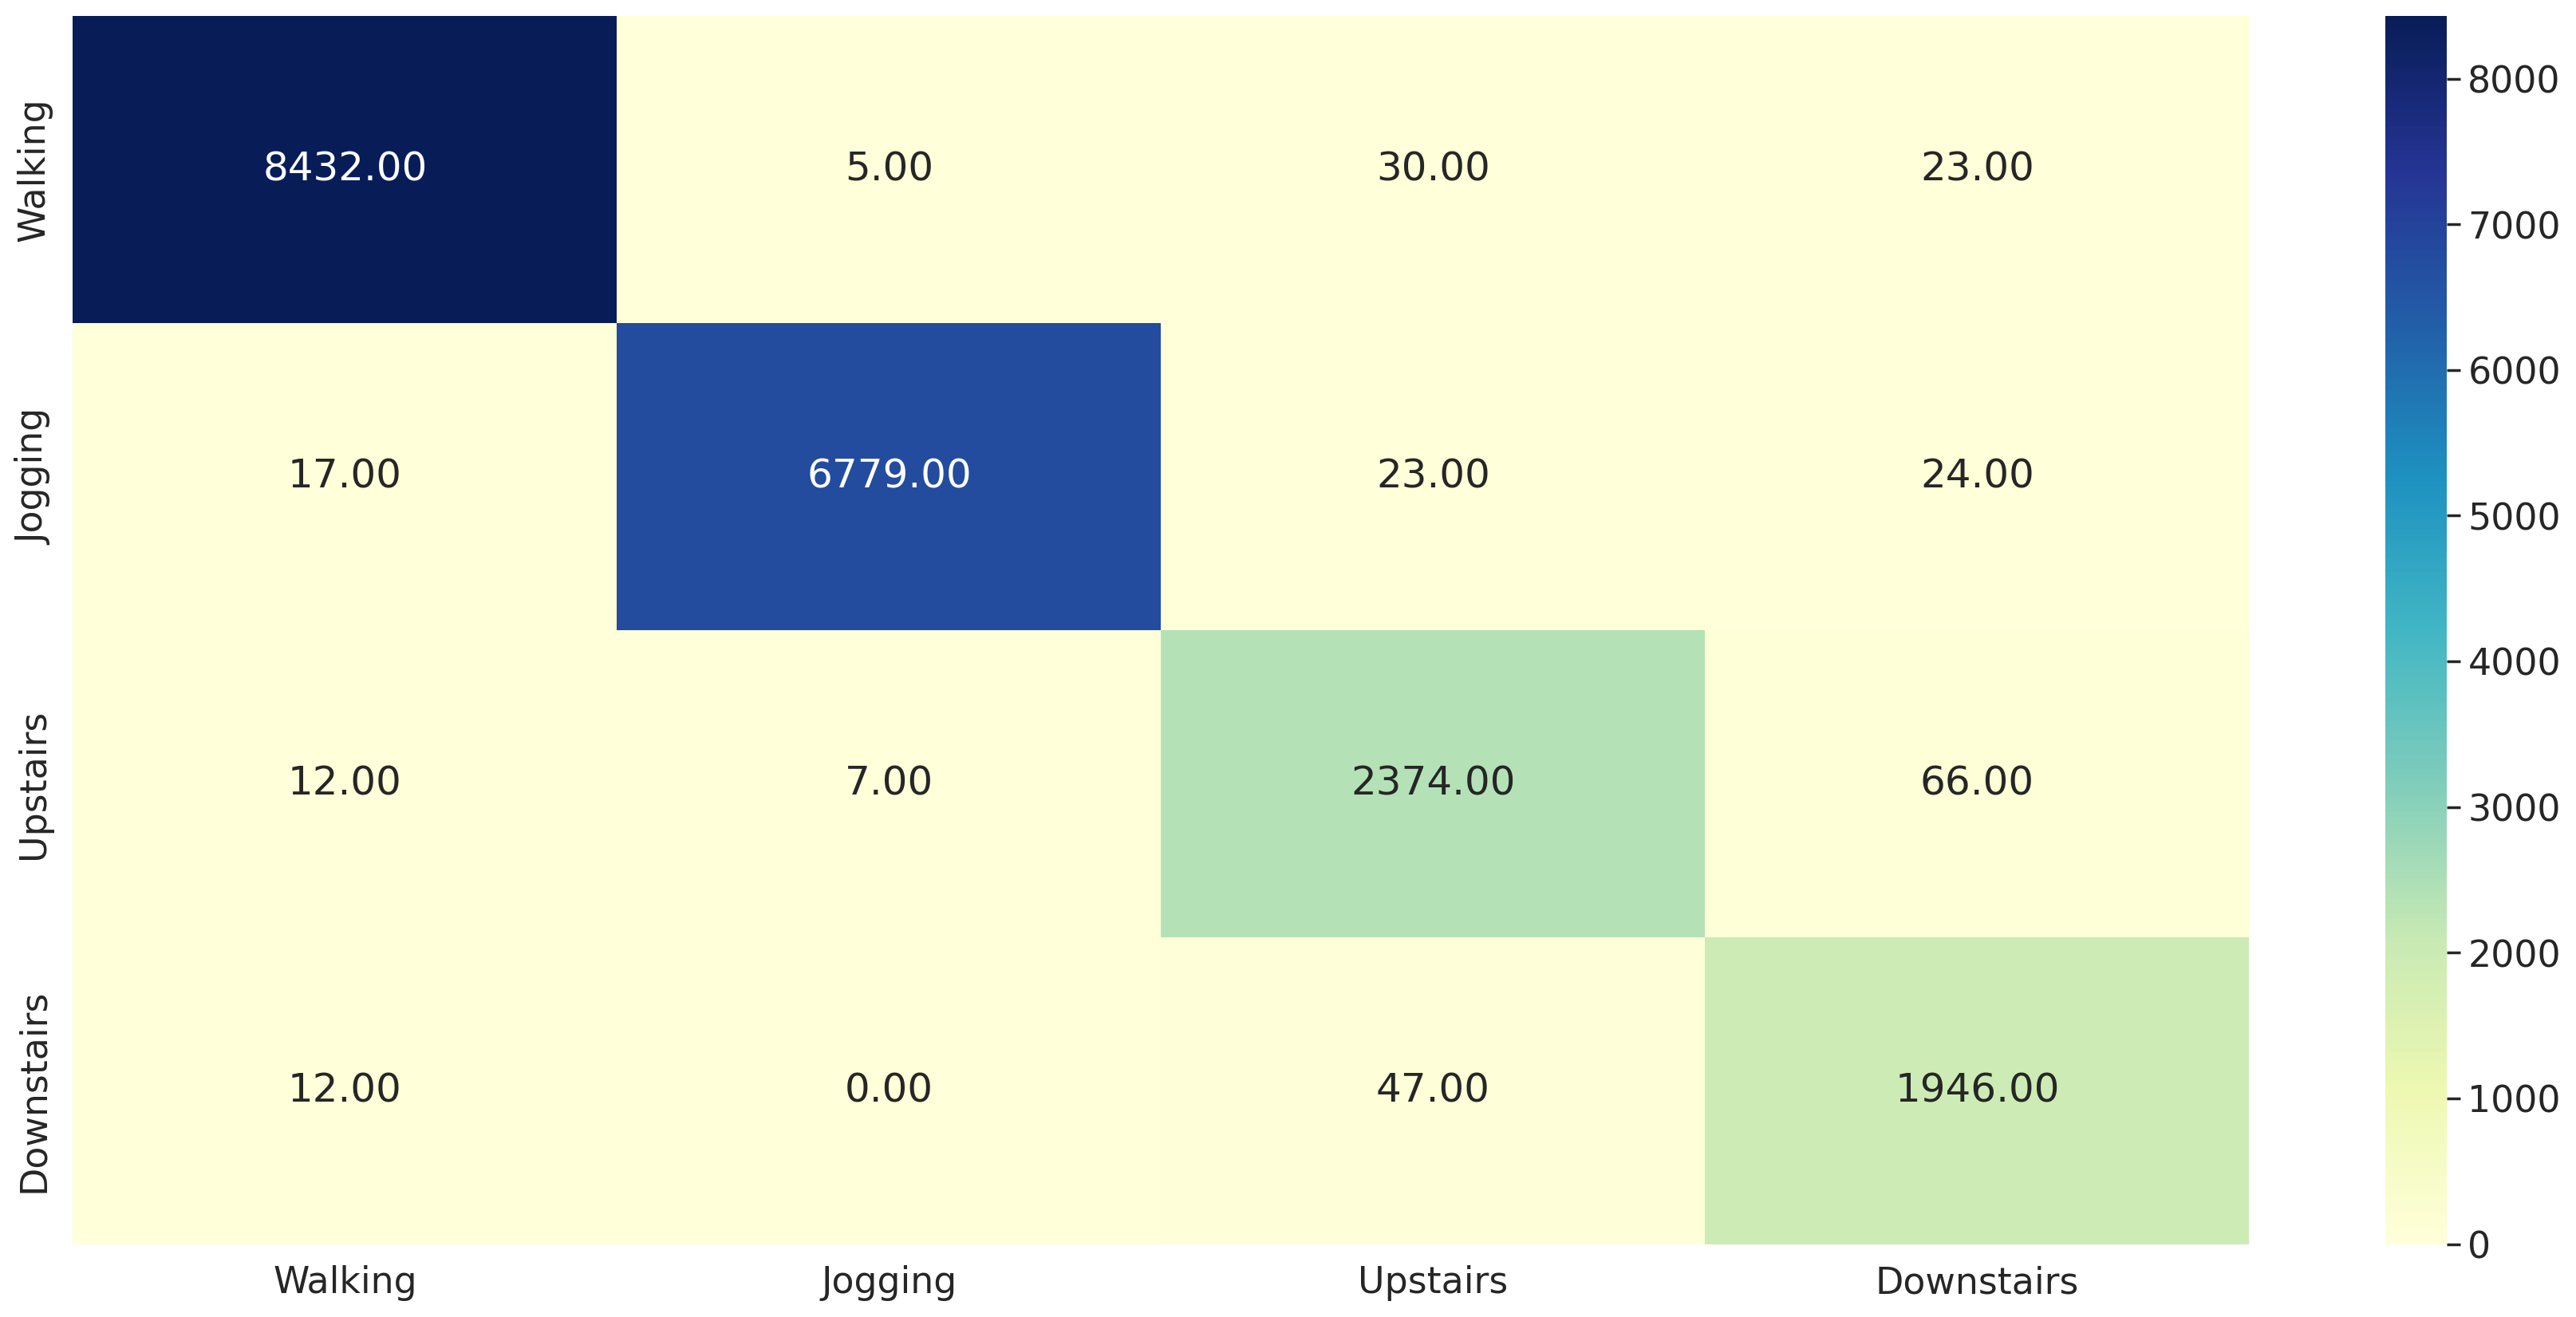

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU3

In [25]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 626s 1s/step - loss: 0.4725 - accuracy: 0.8224 - val_loss: 0.2211 - val_accuracy: 0.9208
Epoch 2/10
495/495 [==============================] - 602s 1s/step - loss: 0.1608 - accuracy: 0.9450 - val_loss: 0.1283 - val_accuracy: 0.9566
Epoch 3/10
495/495 [==============================] - 602s 1s/step - loss: 0.0972 - accuracy: 0.9675 - val_loss: 0.0696 - val_accuracy: 0.9766
Epoch 4/10
495/495 [==============================] - 557s 1s/step - loss: 0.0685 - accuracy: 0.9778 - val_loss: 0.0628 - val_accuracy: 0.9795
Epoch 5/10
495/495 [==============================] - 566s 1s/step - loss: 0.0554 - accuracy: 0.9820 - val_loss: 0.0468 - val_accuracy: 0.9854
Epoch 6/10
495/495 [==============================] - 599s 1s/step - loss: 0.0436 - accuracy: 0.9854 - val_loss: 0.0452 - val_accuracy: 0.9847
Epoch 7/10
495/495 [==============================] - 560s 1s/step - loss: 0.0370 - accuracy: 0.9878 - val_loss: 0.0408 - val_accuracy: 0.9874

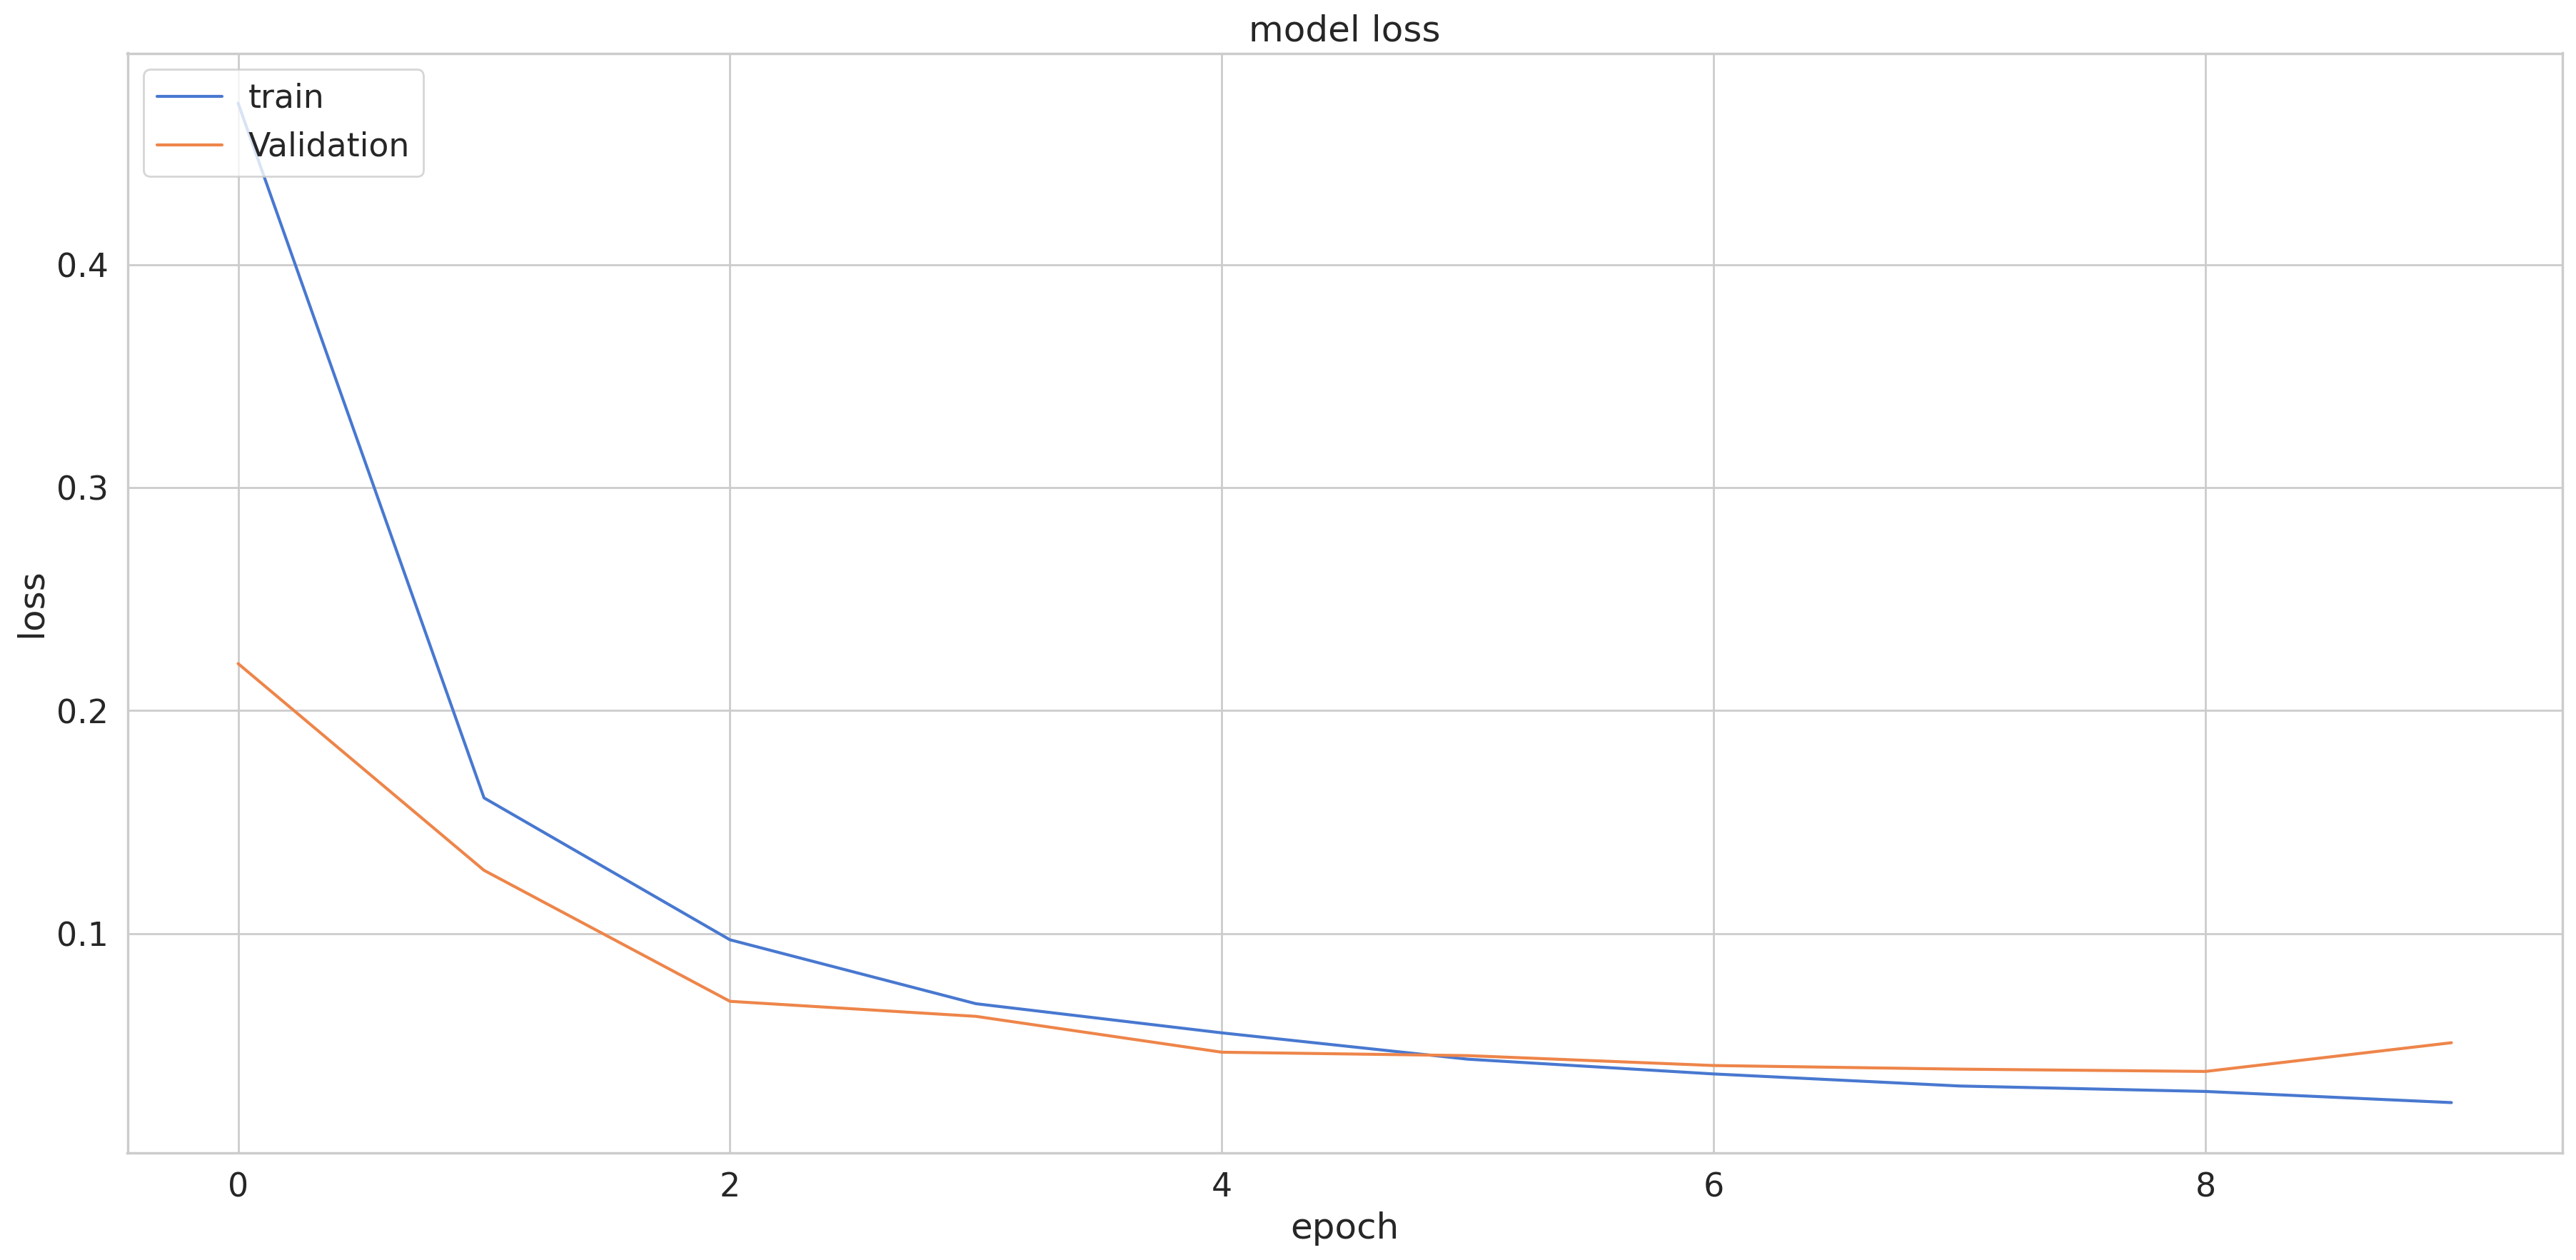

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

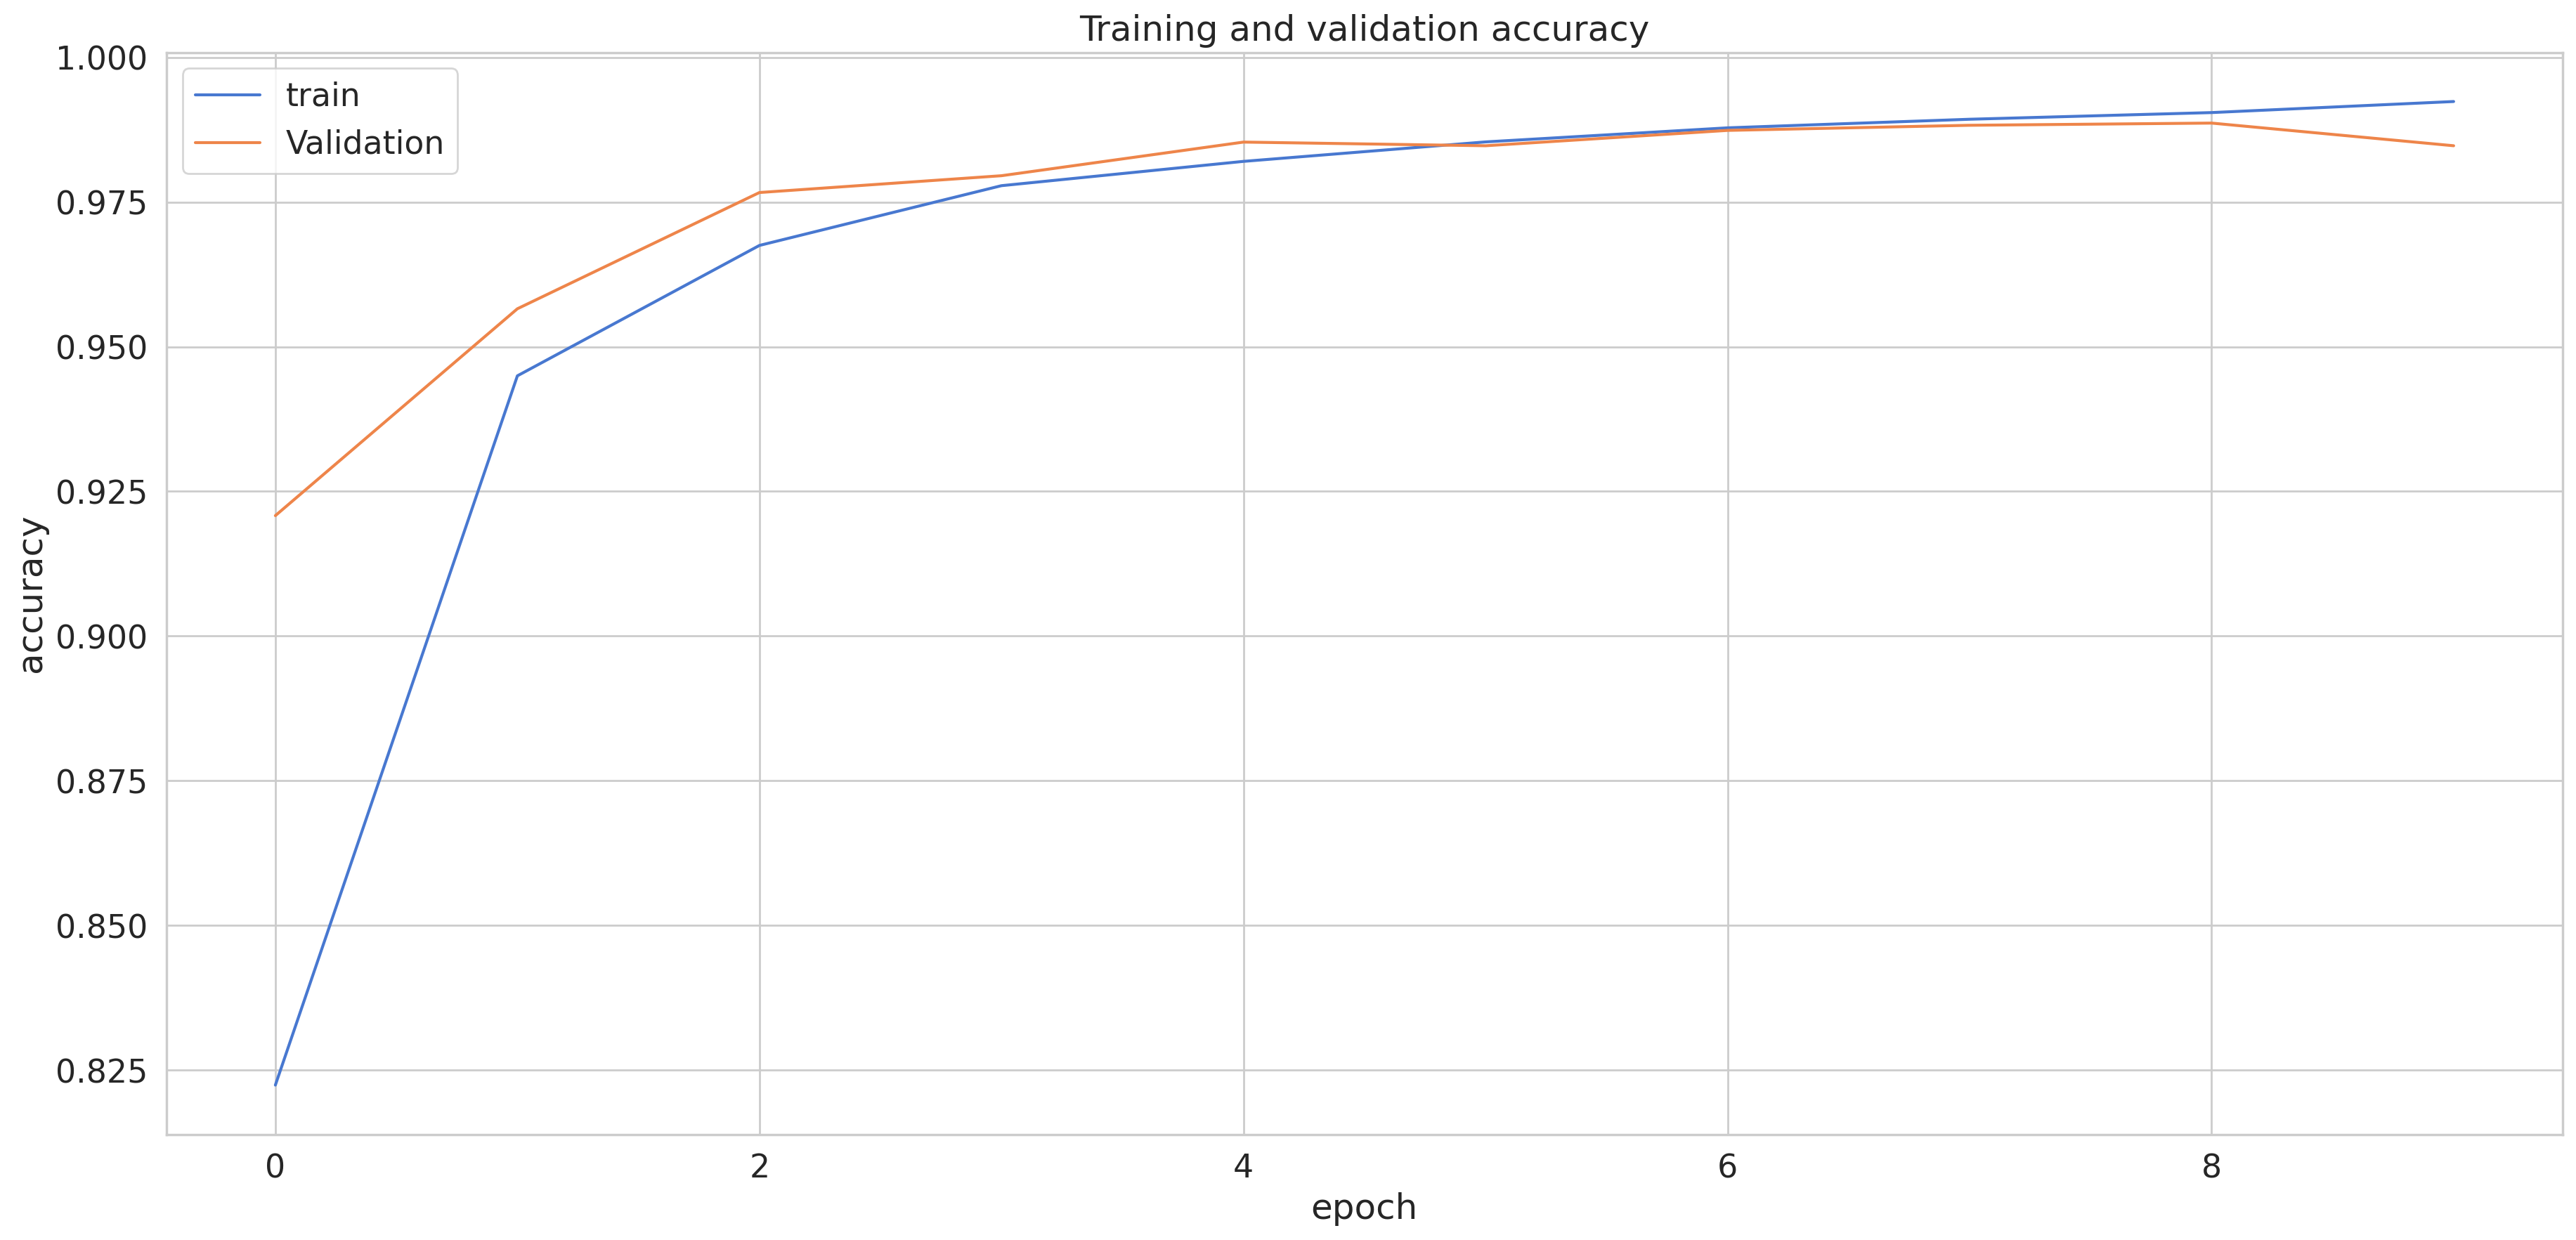

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 80s 126ms/step
f1_score =  0.9851142170442739
0.9849472142243775
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.92      0.99      0.95      2459
           3       0.97      0.96      0.97      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.98      0.98     19797
weighted avg       0.99      0.98      0.99     19797



<Axes: >

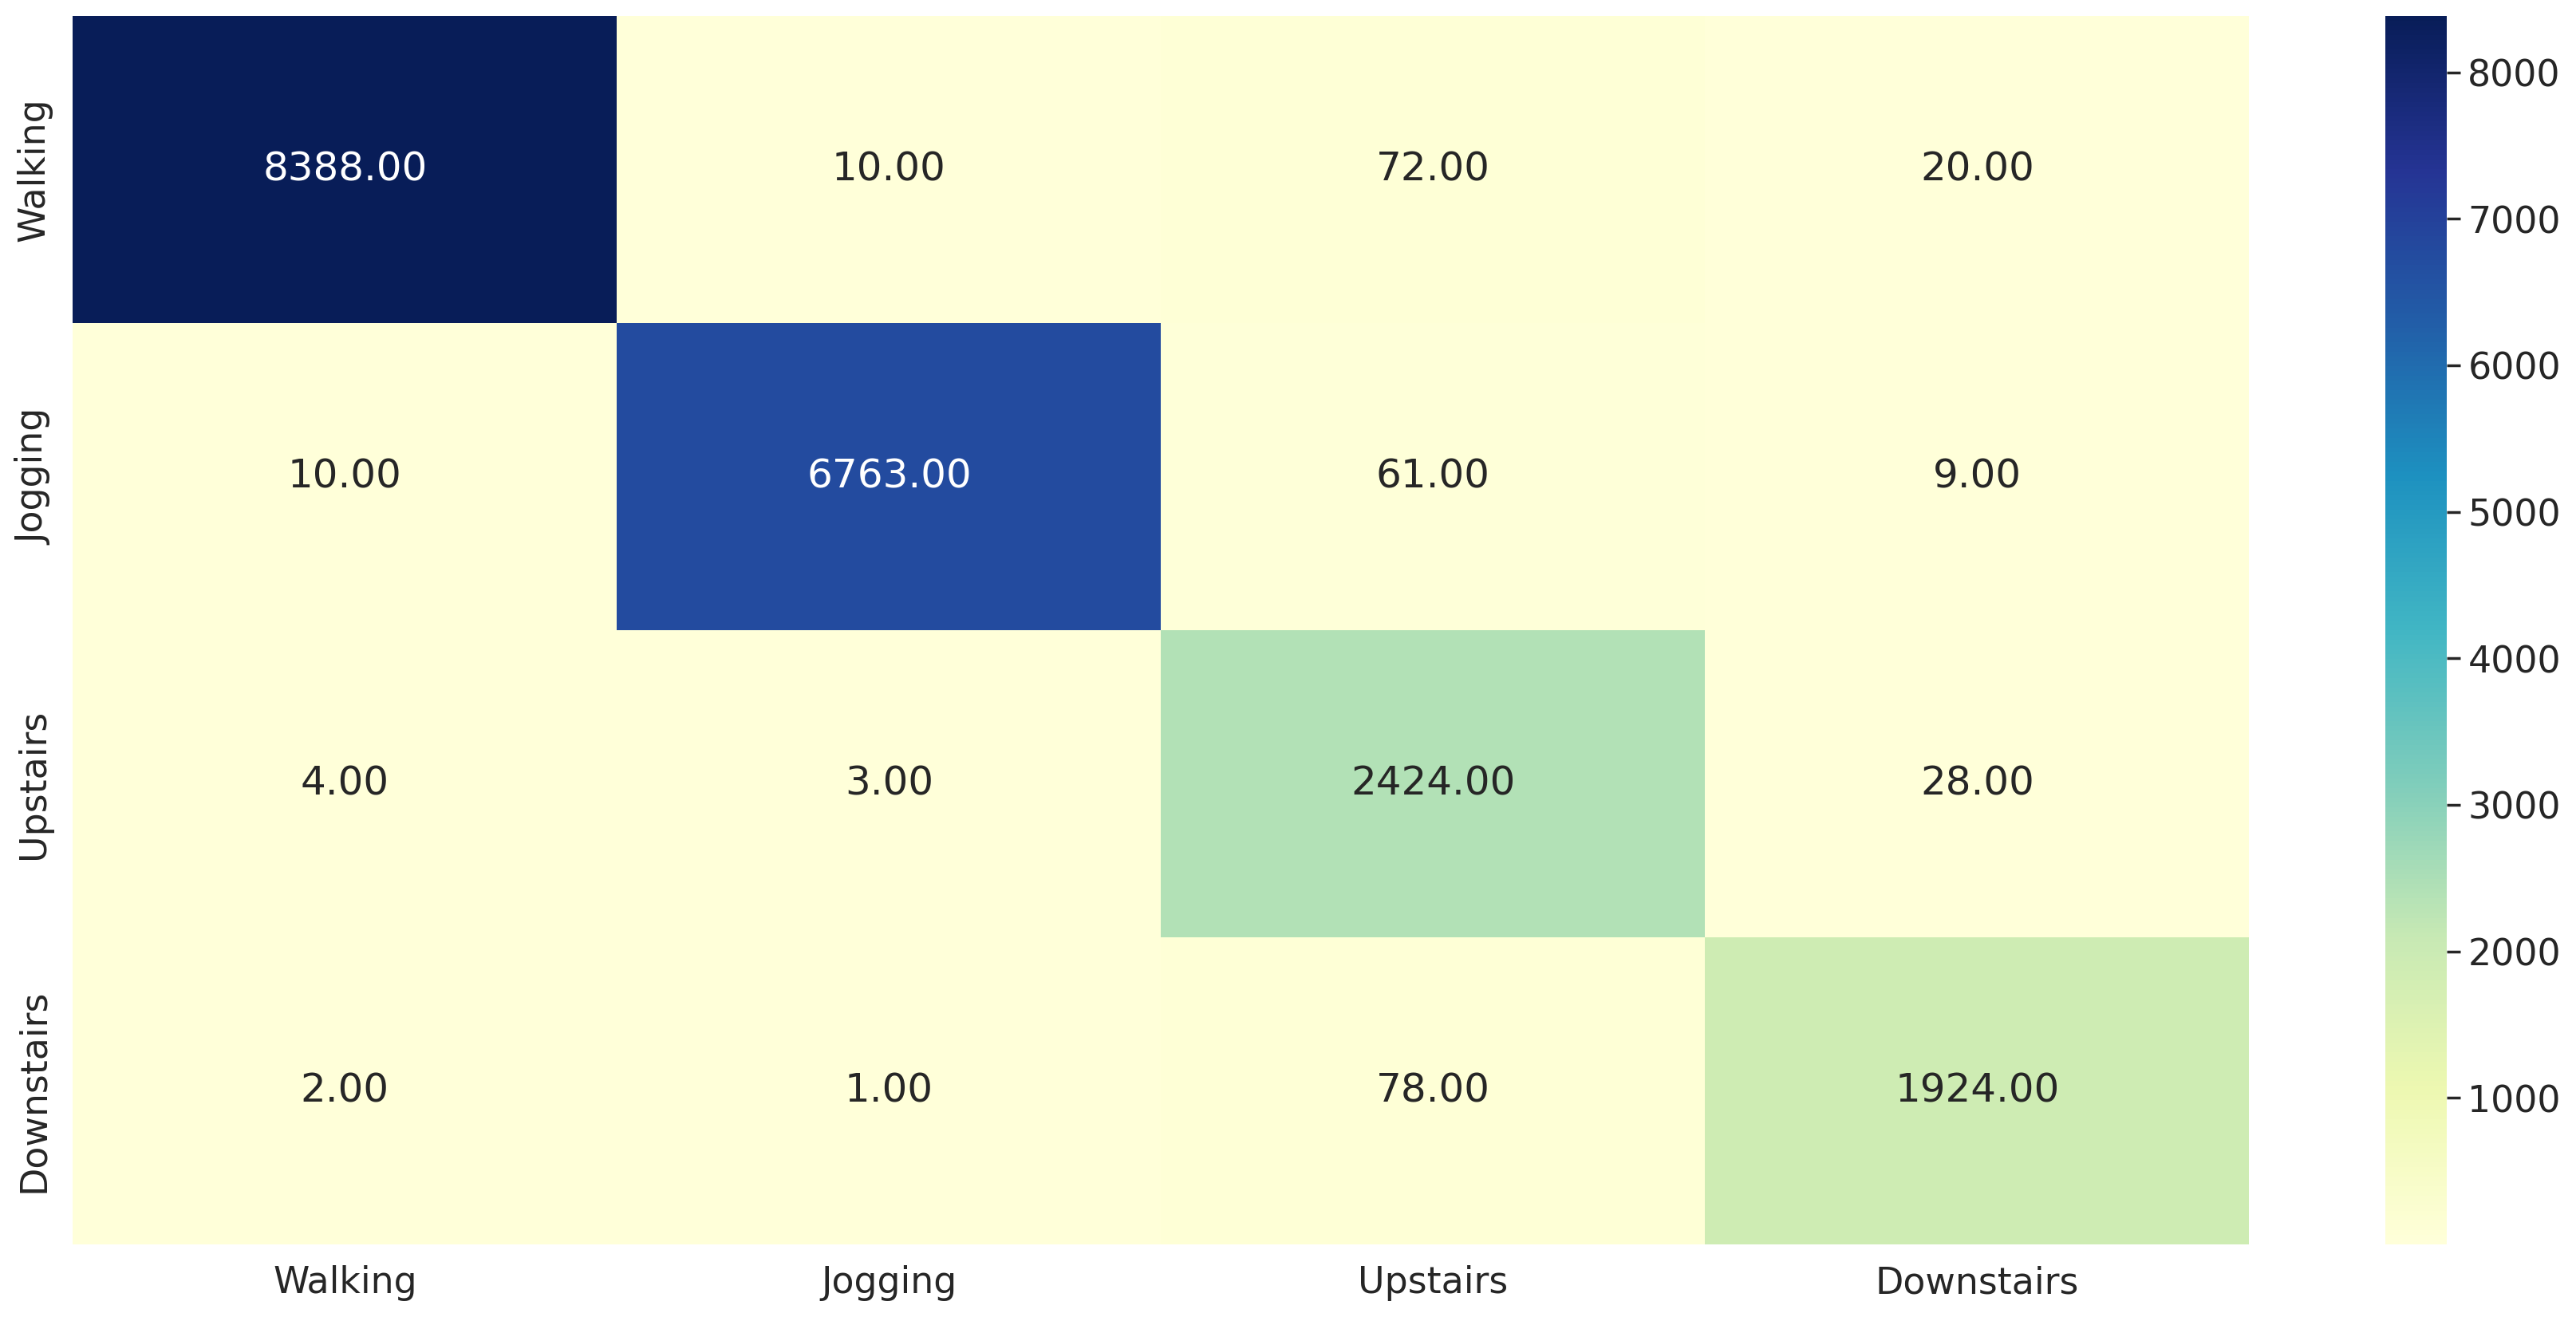

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU4

In [30]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 835s 2s/step - loss: 0.4588 - accuracy: 0.8289 - val_loss: 0.1831 - val_accuracy: 0.9367
Epoch 2/10
495/495 [==============================] - 818s 2s/step - loss: 0.1564 - accuracy: 0.9474 - val_loss: 0.1140 - val_accuracy: 0.9633
Epoch 3/10
495/495 [==============================] - 813s 2s/step - loss: 0.0948 - accuracy: 0.9692 - val_loss: 0.0723 - val_accuracy: 0.9779
Epoch 4/10
495/495 [==============================] - 810s 2s/step - loss: 0.0675 - accuracy: 0.9787 - val_loss: 0.0661 - val_accuracy: 0.9797
Epoch 5/10
495/495 [==============================] - 813s 2s/step - loss: 0.0545 - accuracy: 0.9822 - val_loss: 0.0513 - val_accuracy: 0.9849
Epoch 6/10
495/495 [==============================] - 810s 2s/step - loss: 0.0456 - accuracy: 0.9851 - val_loss: 0.0456 - val_accuracy: 0.9864
Epoch 7/10
495/495 [==============================] - 809s 2s/step - loss: 0.0371 - accuracy: 0.9878 - val_loss: 0.0432 - val_accuracy: 0.9880

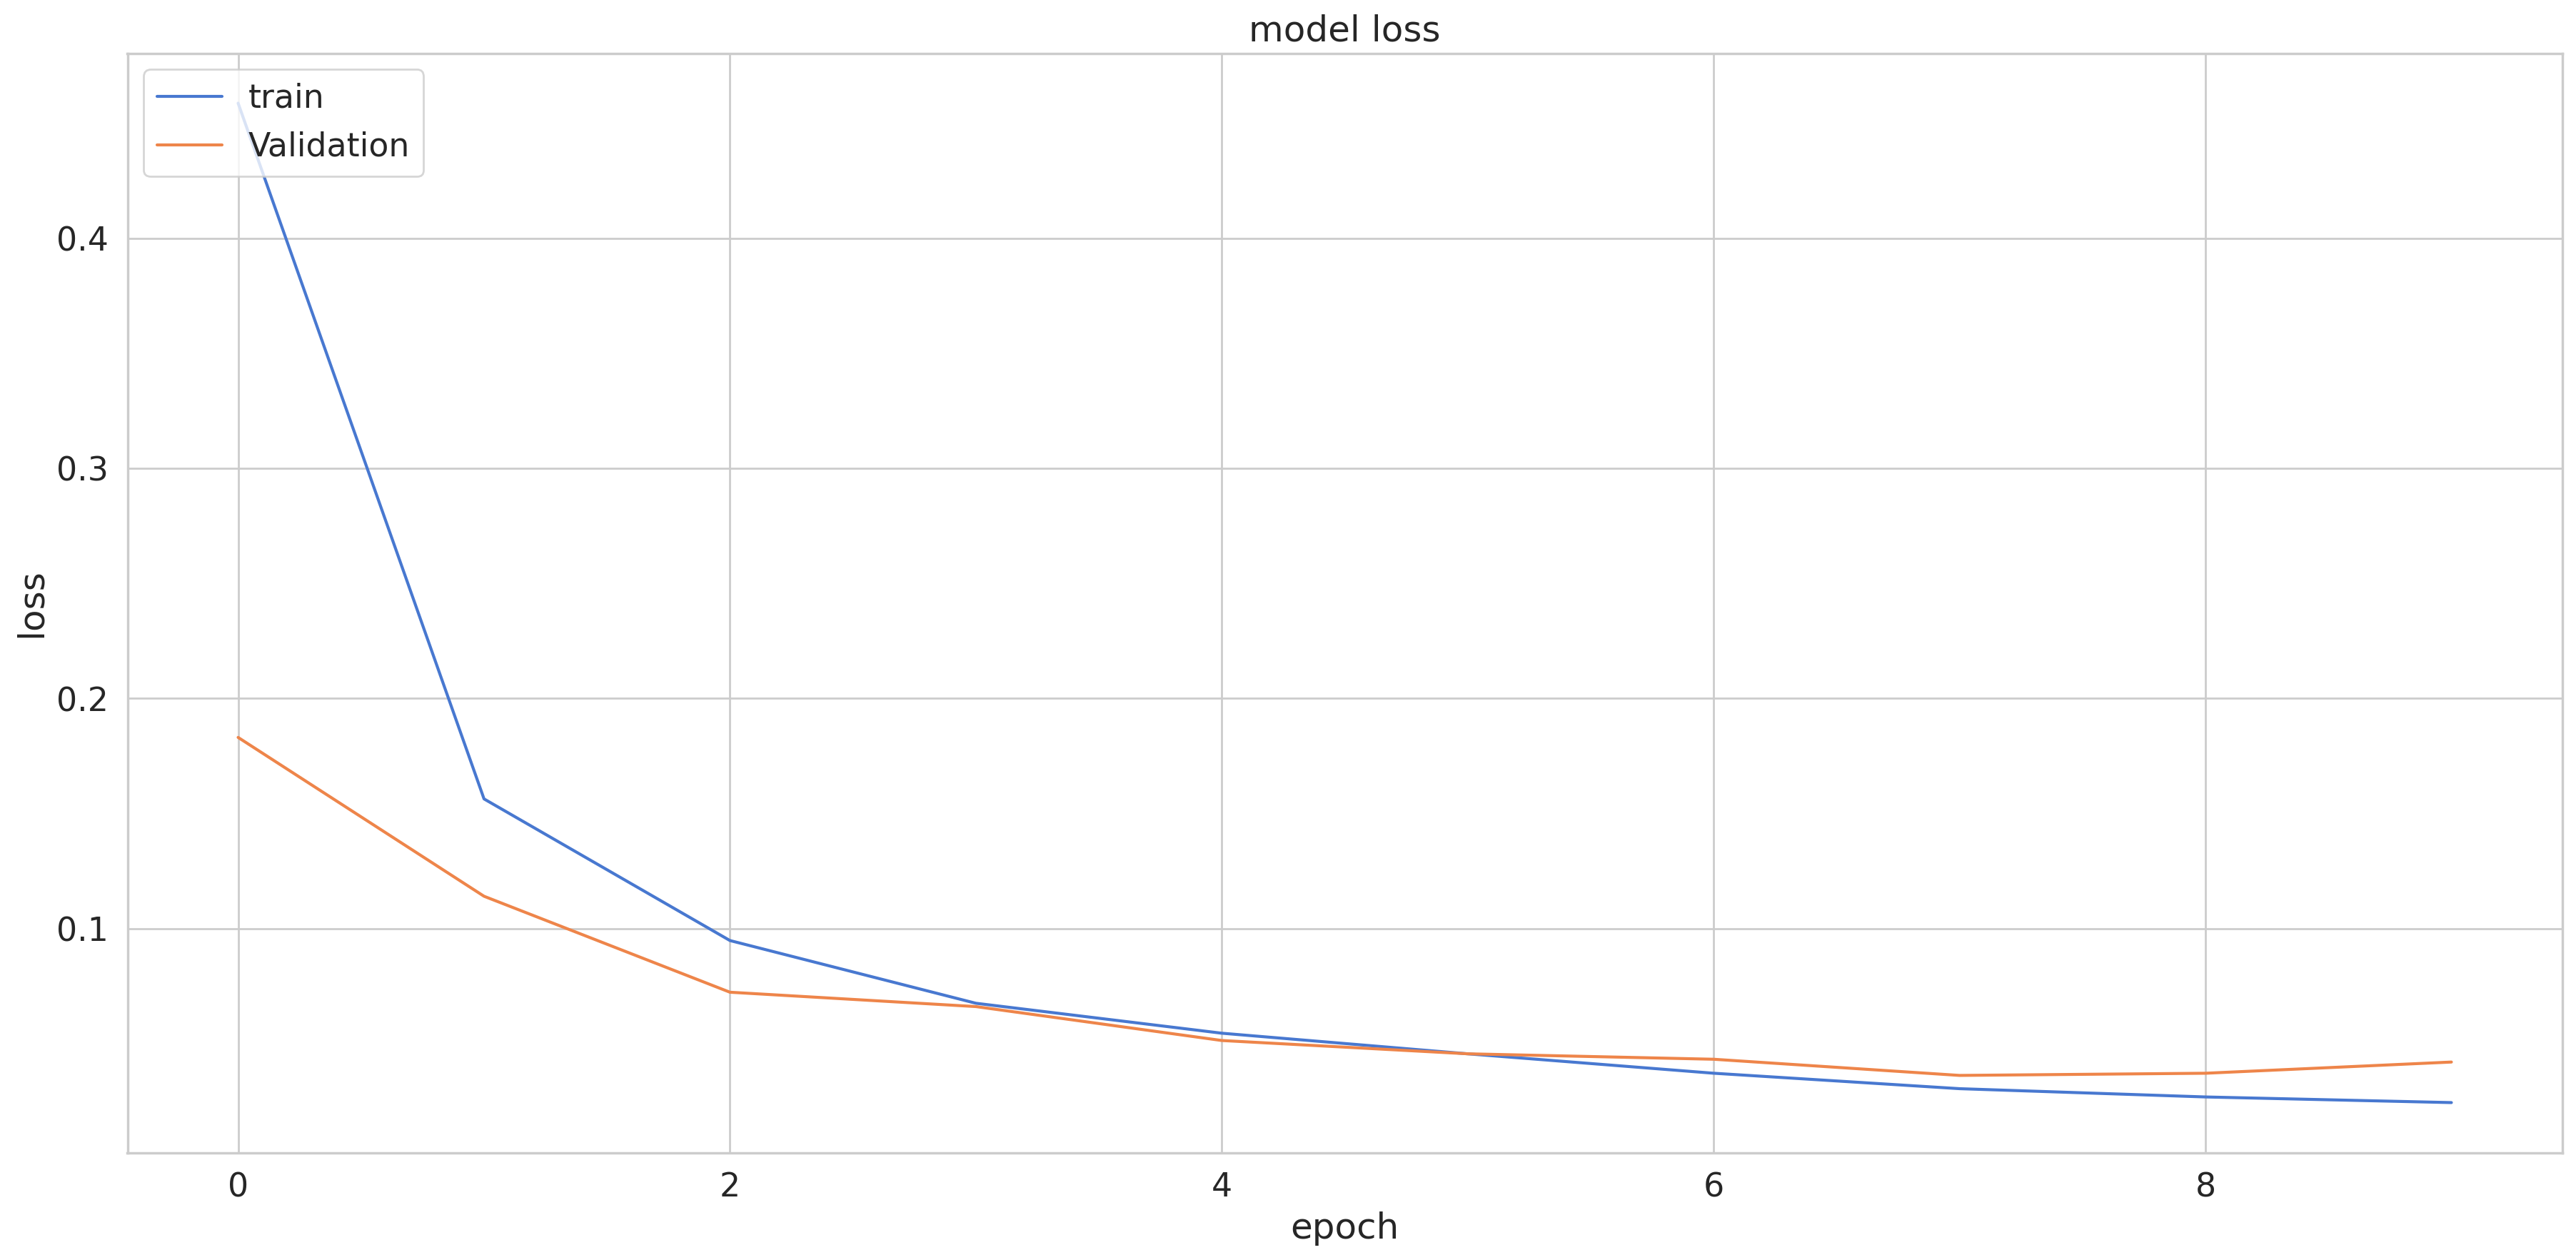

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

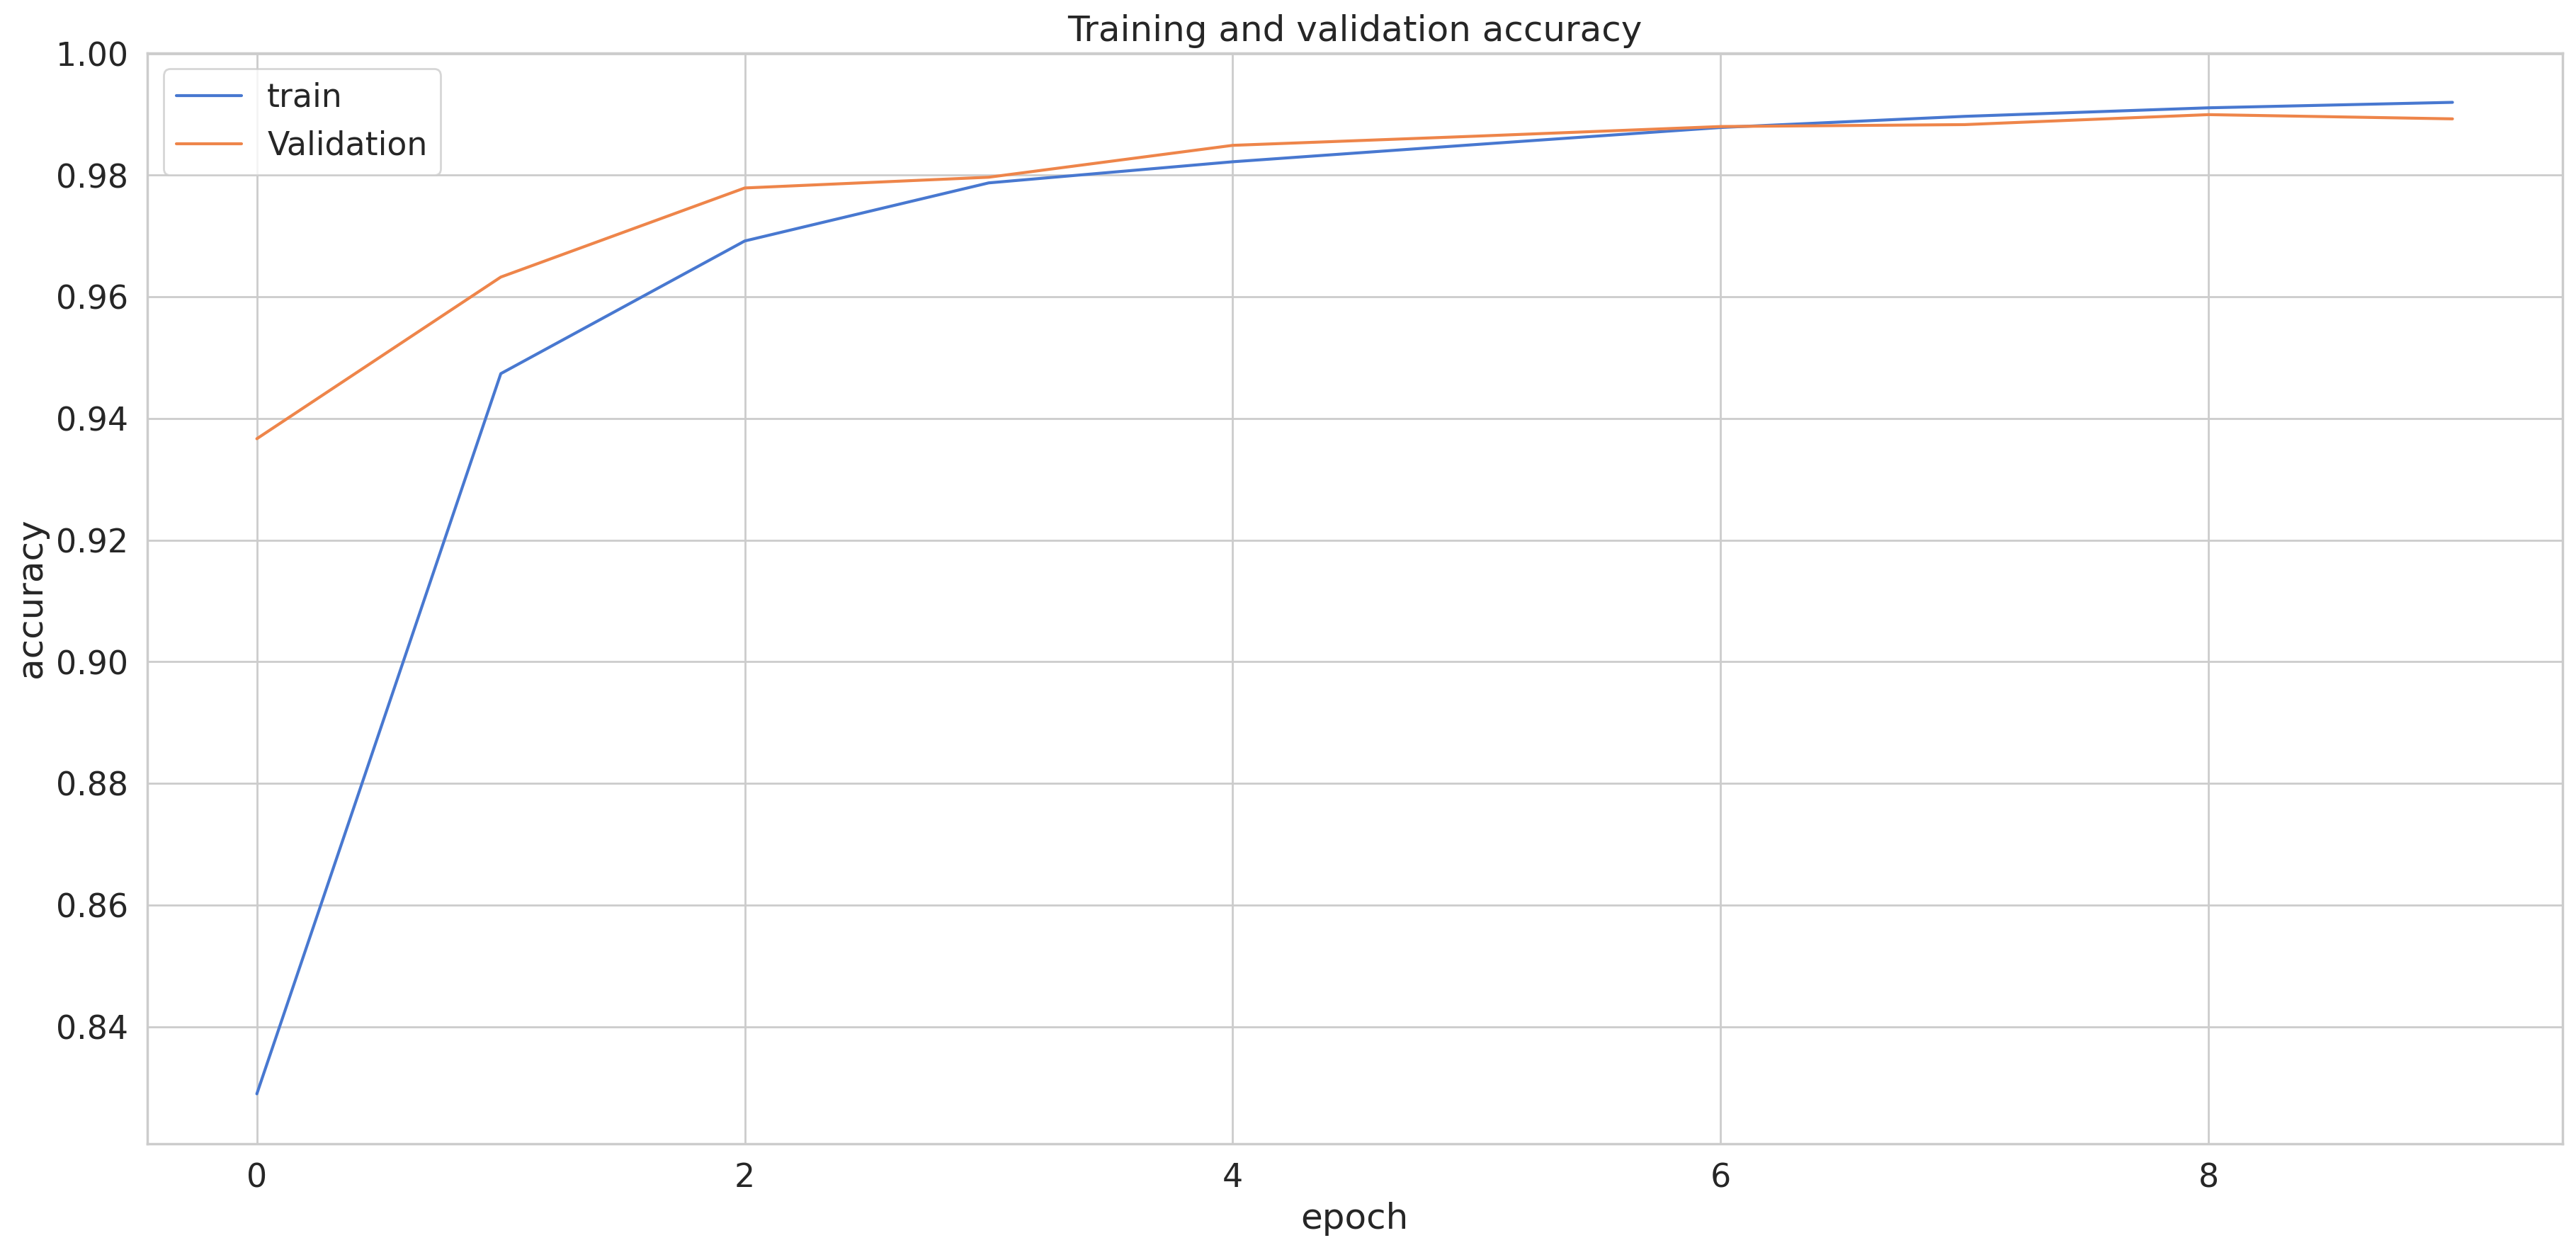

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 117s 179ms/step
f1_score =  0.9877553334481294
0.9877759256452998
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8490
           1       0.99      1.00      0.99      6843
           2       0.97      0.96      0.97      2459
           3       0.96      0.96      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

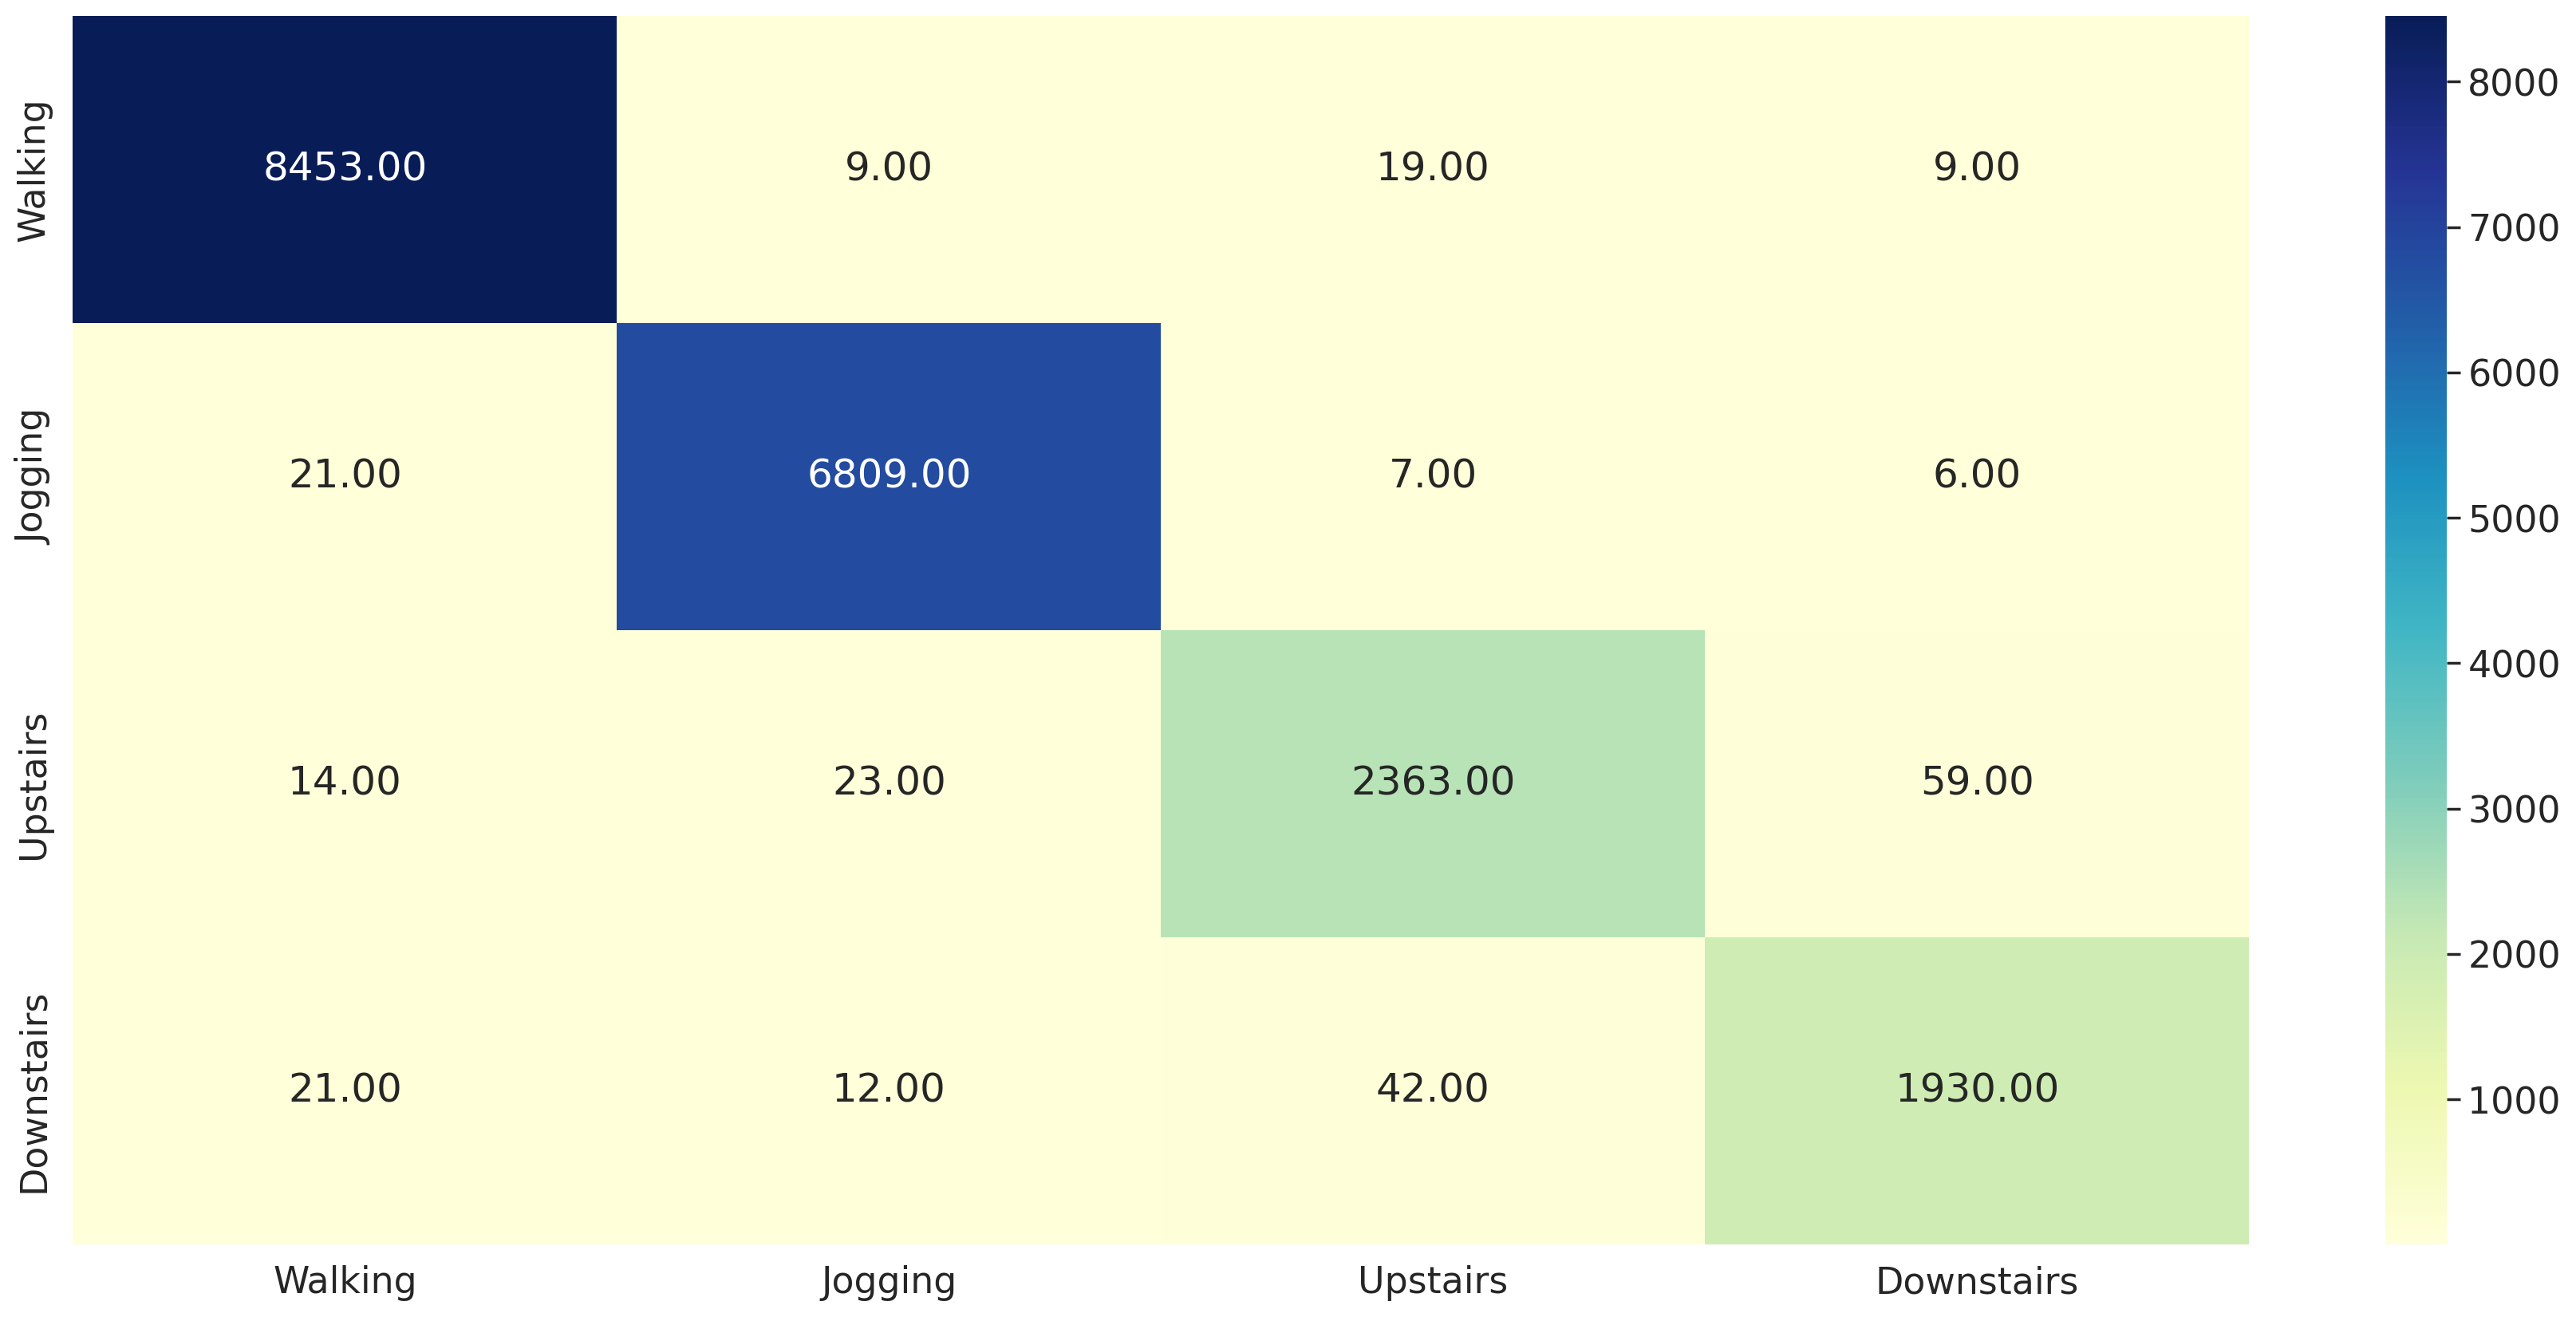

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [35]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 128)           51072     
                                                                 
 dropout_10 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_11 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_12 (GRU)                (None, 50, 128)           99072     
                                                                 
 dropout_12 (Dropout)        (None, 50, 128)           0         
                                                                 
 gru_13 (GRU)                (None, 50, 128)          

In [36]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 434s 854ms/step - loss: 0.5384 - accuracy: 0.8003 - val_loss: 0.2747 - val_accuracy: 0.9062
Epoch 2/10
495/495 [==============================] - 428s 866ms/step - loss: 0.2268 - accuracy: 0.9228 - val_loss: 0.1710 - val_accuracy: 0.9434
Epoch 3/10
495/495 [==============================] - 426s 861ms/step - loss: 0.1513 - accuracy: 0.9508 - val_loss: 0.1141 - val_accuracy: 0.9616
Epoch 4/10
495/495 [==============================] - 425s 858ms/step - loss: 0.1097 - accuracy: 0.9640 - val_loss: 0.0987 - val_accuracy: 0.9668
Epoch 5/10
495/495 [==============================] - 429s 866ms/step - loss: 0.0845 - accuracy: 0.9726 - val_loss: 0.0832 - val_accuracy: 0.9724
Epoch 6/10
495/495 [==============================] - 429s 867ms/step - loss: 0.0721 - accuracy: 0.9767 - val_loss: 0.0633 - val_accuracy: 0.9798
Epoch 7/10
495/495 [==============================] - 429s 867ms/step - loss: 0.0577 - accuracy: 0.9811 - val_loss: 0.0505 -

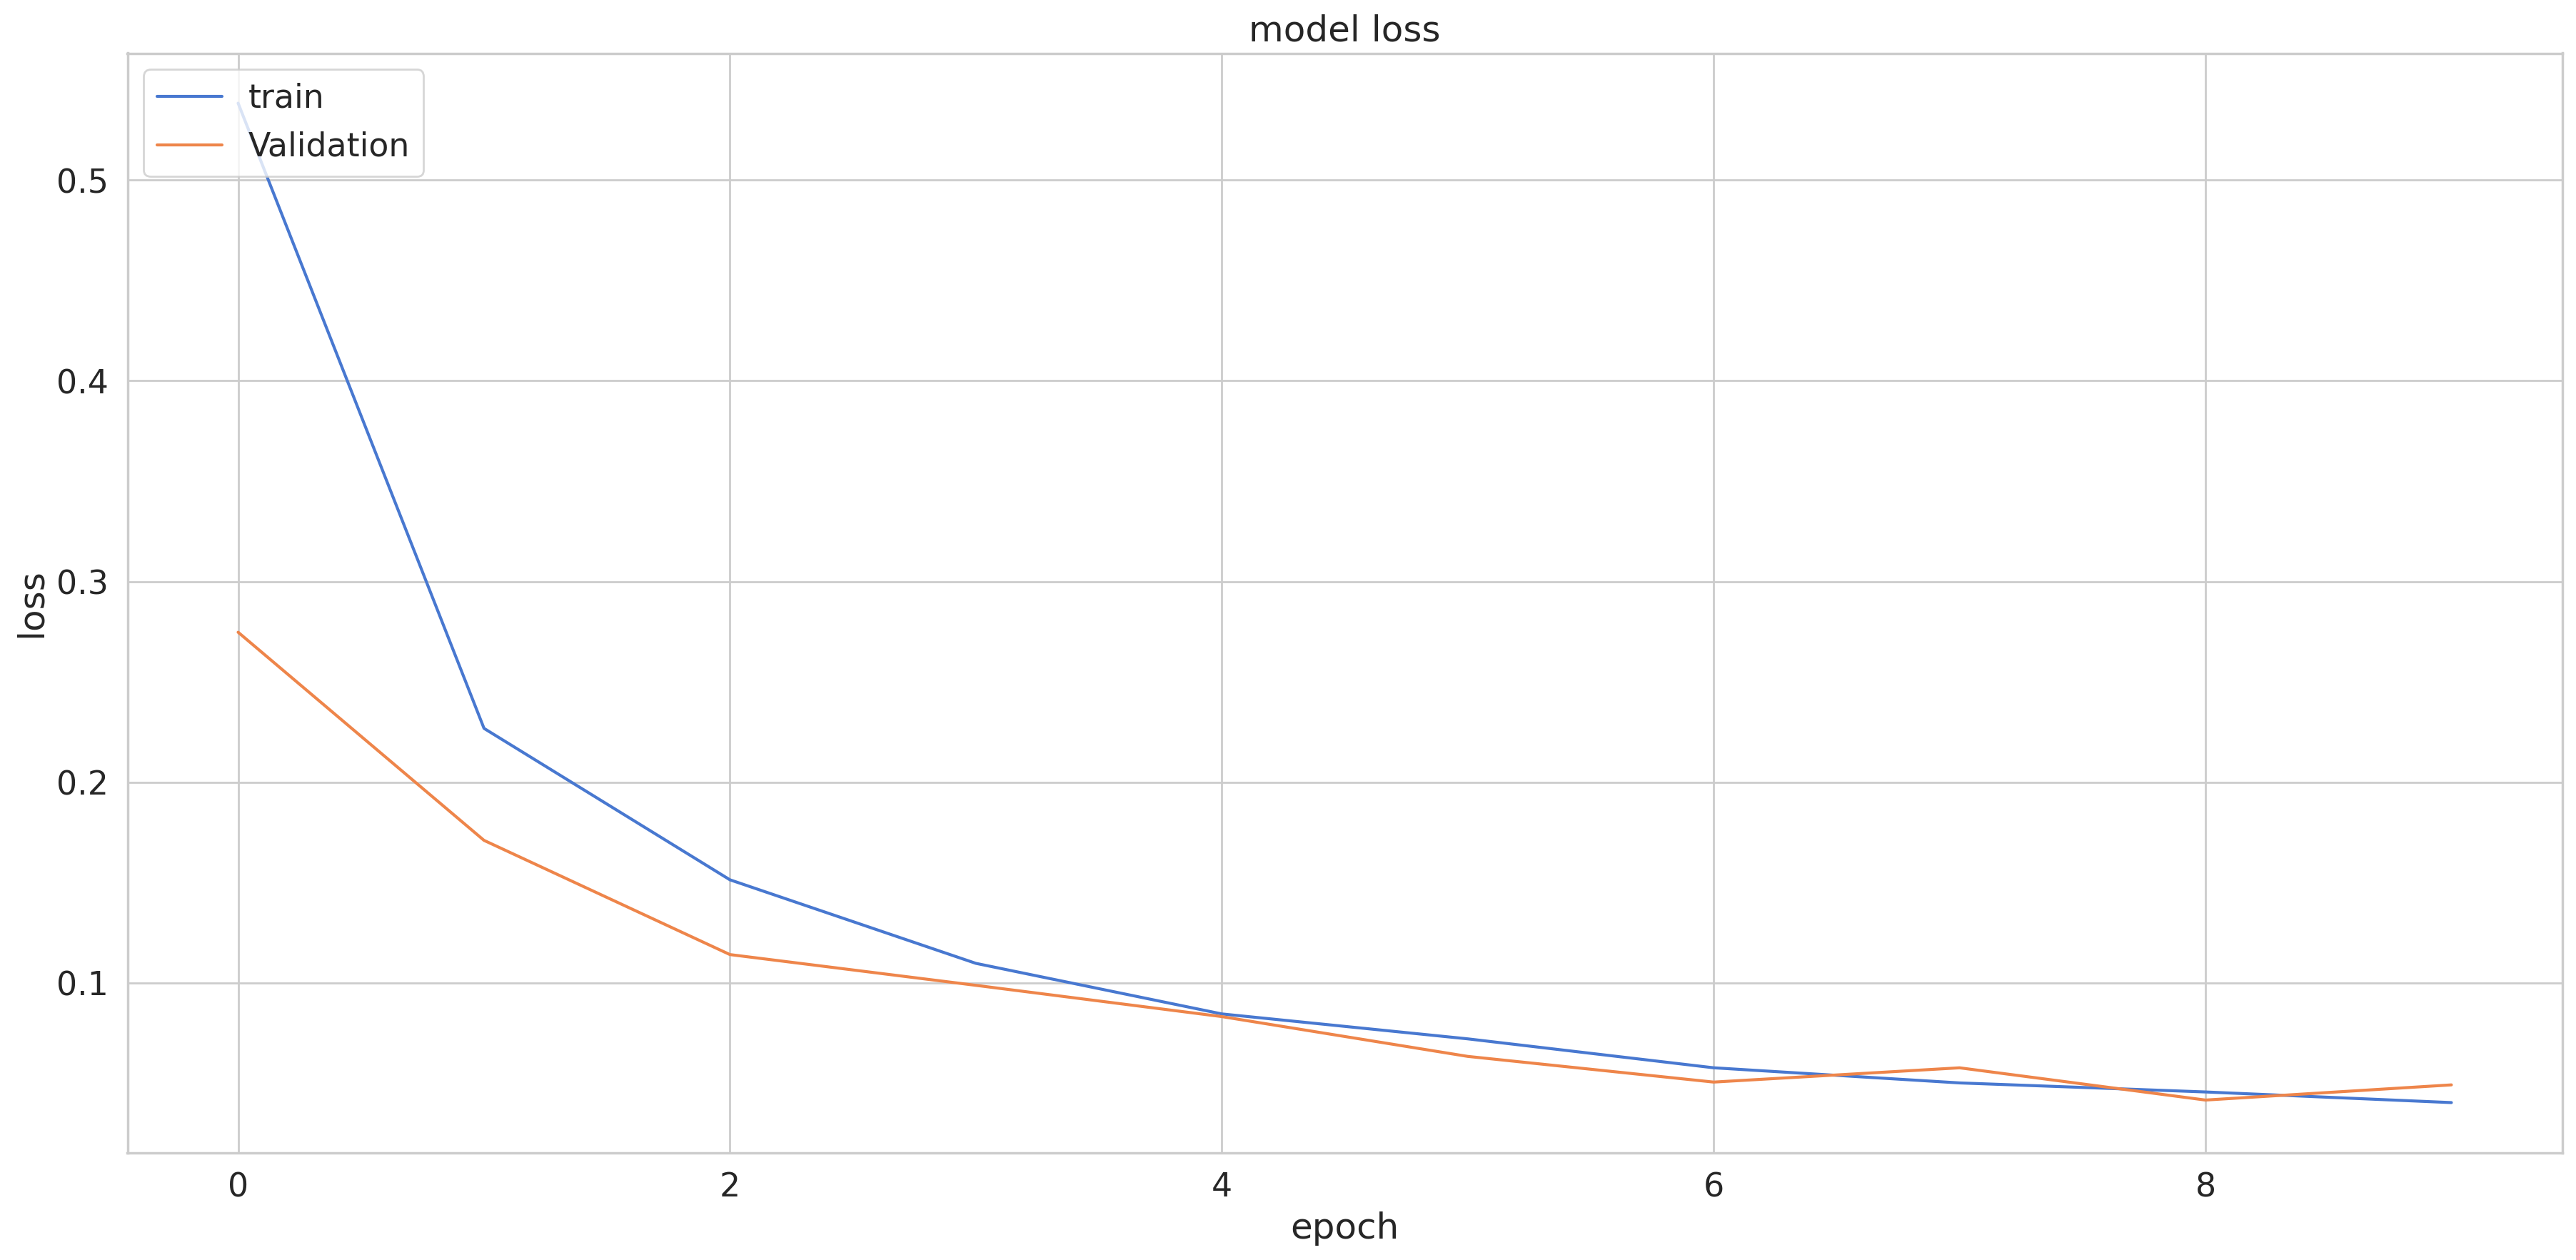

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

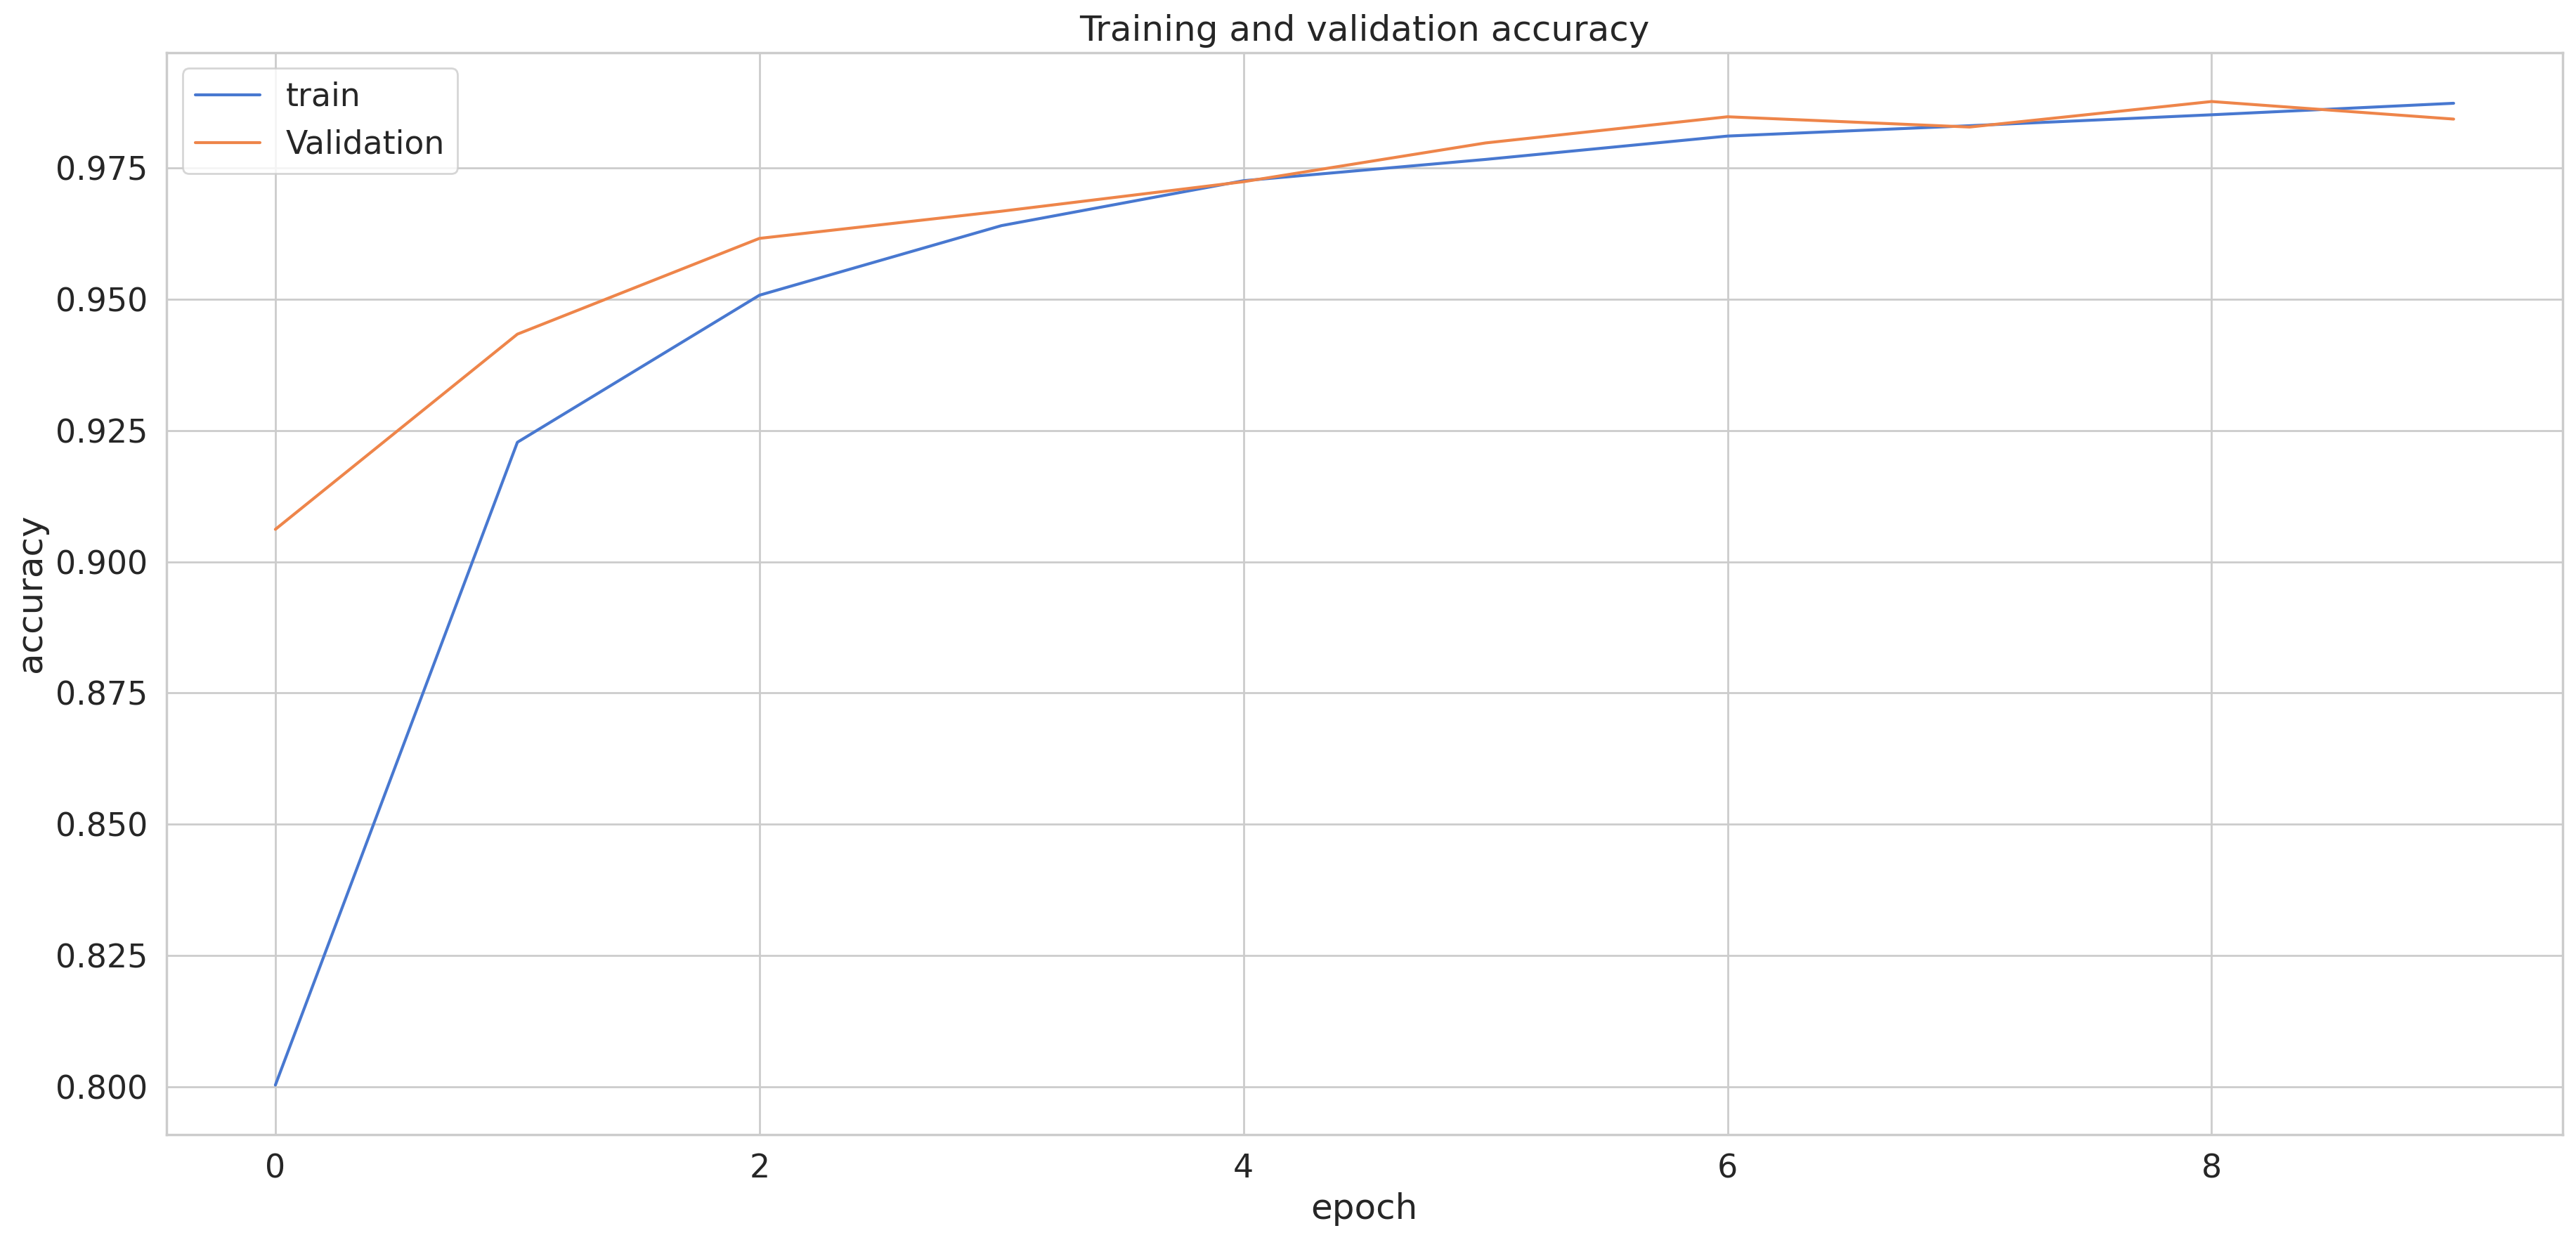

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 52s 80ms/step
f1_score =  0.9857529407004788
0.9857554174874981
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.97      0.95      0.96      2459
           3       0.95      0.97      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

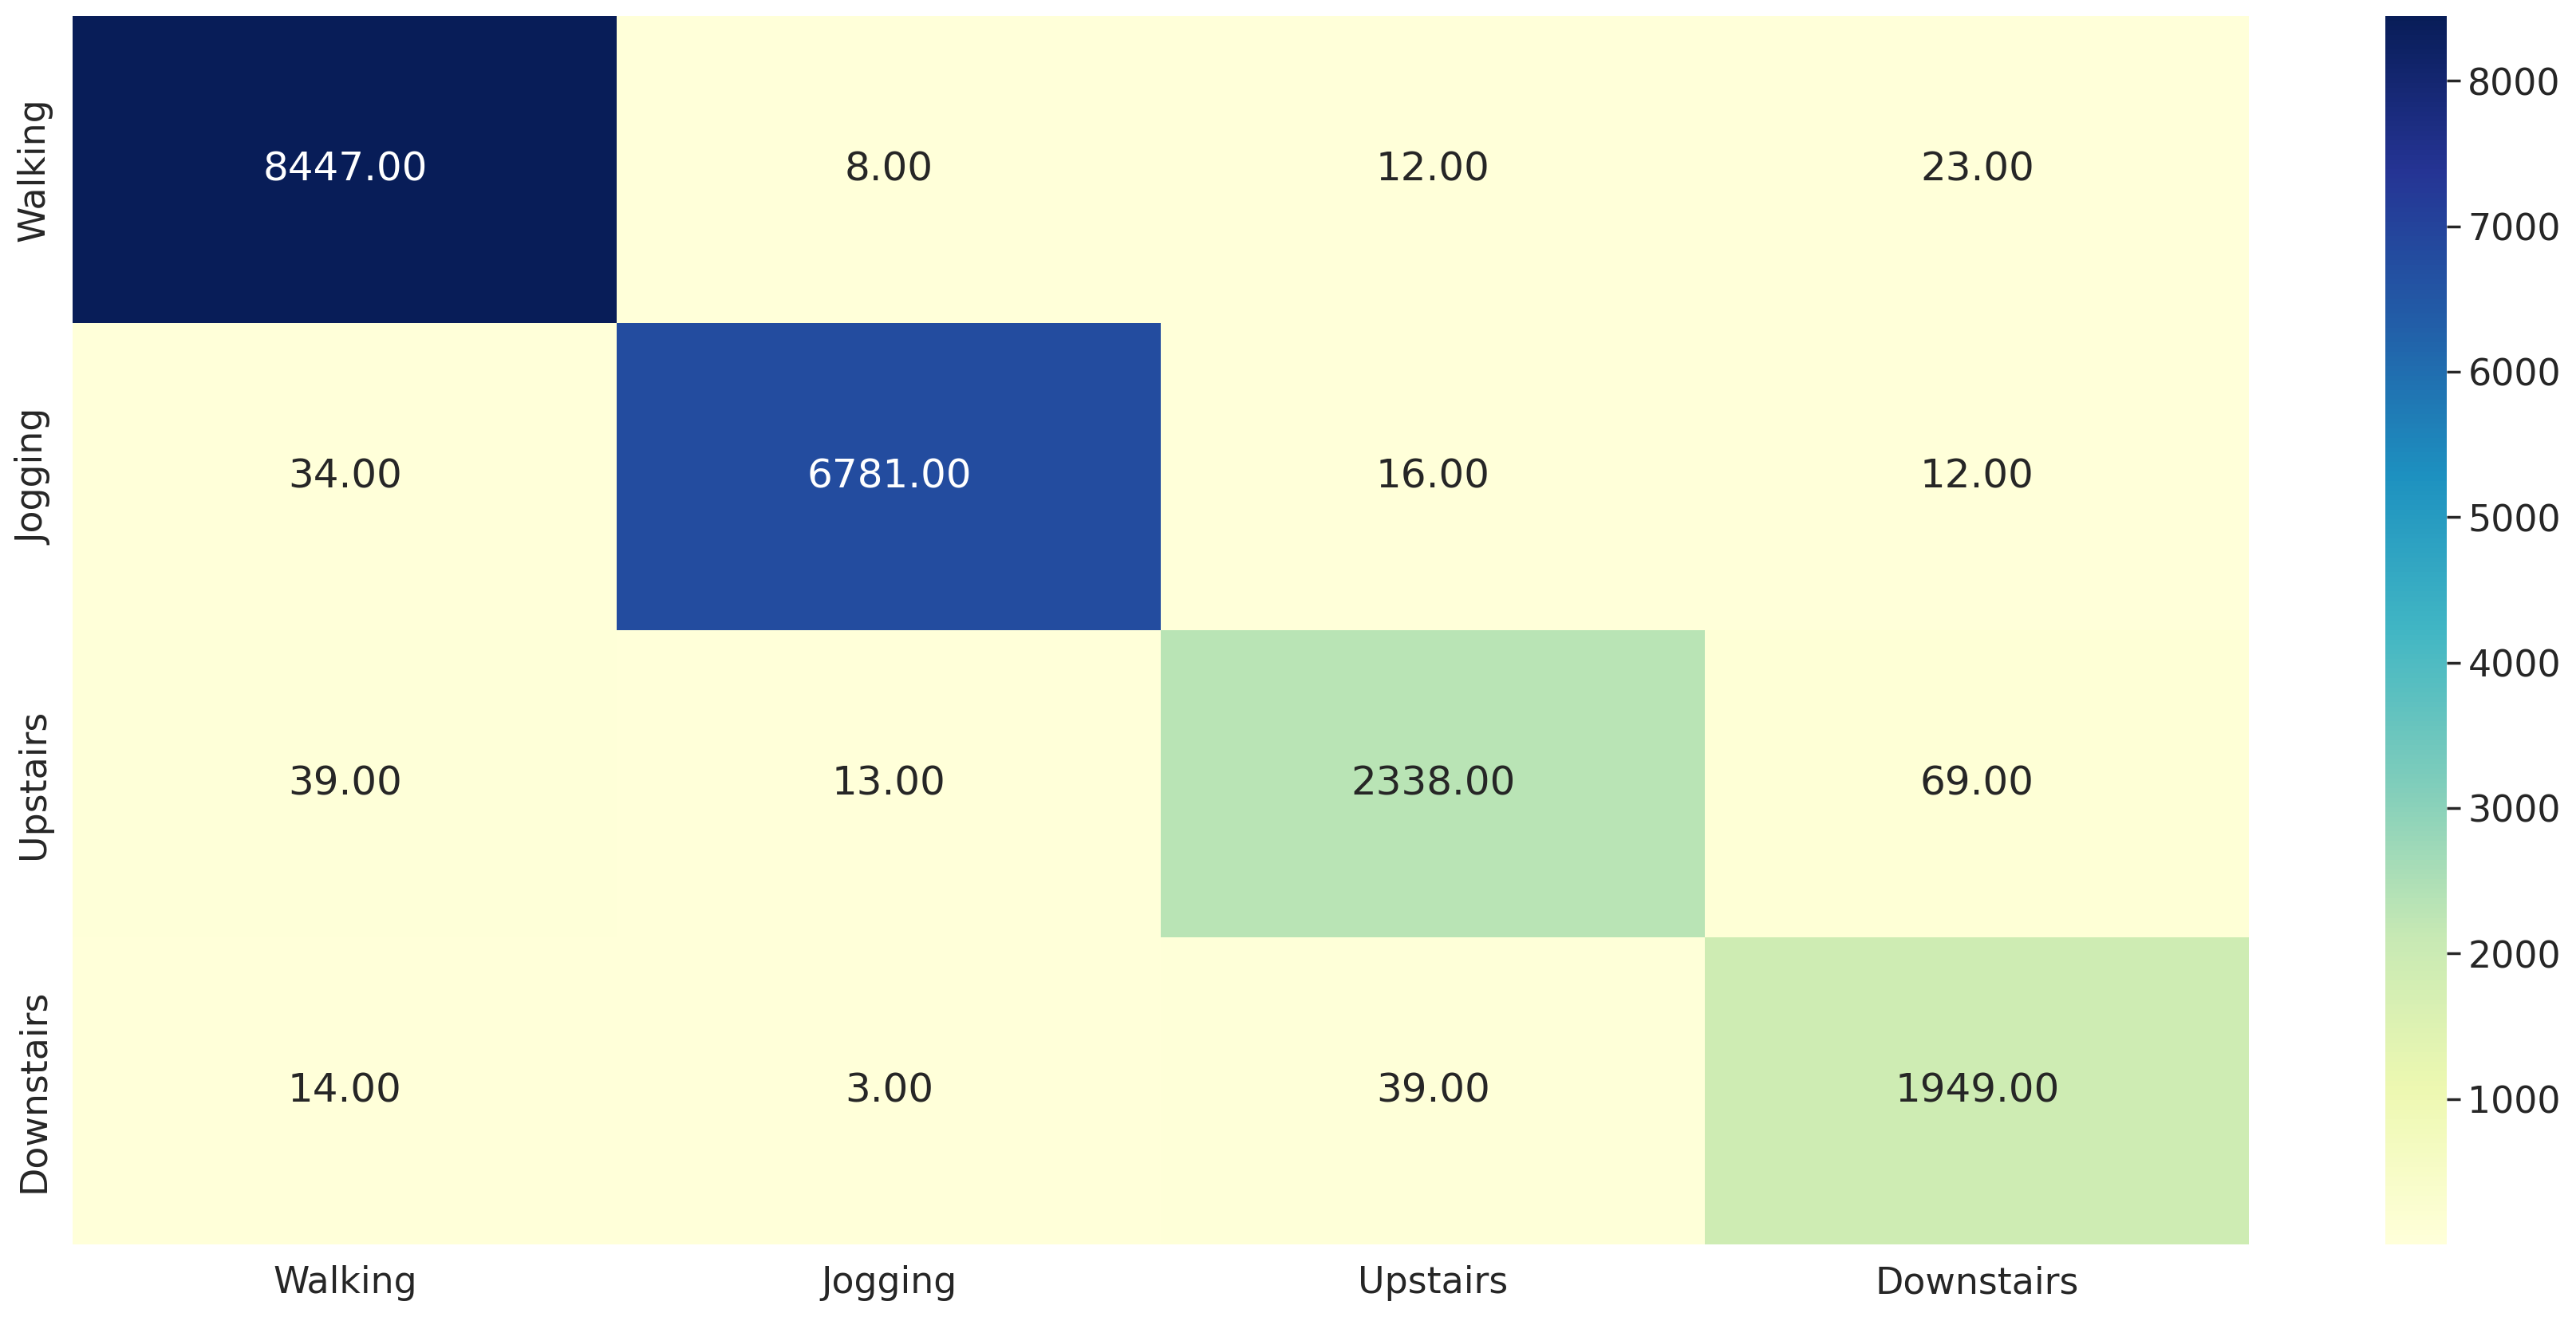

In [39]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')